In [14]:
import time
from spade.agent import Agent
from spade.behaviour import CyclicBehaviour, PeriodicBehaviour, OneShotBehaviour, FSMBehaviour, State
from spade.message import Message
from spade.template import Template
import json
import asyncio
from random import random
from copy import deepcopy
import pandas as pd

import dash
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.express as px
from dash import Input, Output, dcc, html

from datetime import datetime
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np

In [15]:
password="Secret777"

In [16]:
jid ="user@localhost"

In [17]:
class MachineAgent(Agent):

    def __init__(self, jid, password, verify_security, inputs, outputs, production_time, chance_to_break, magazine, item_prices, euro, up_price, down_price, providers, maintainers, stock):
        self.inputs=inputs
        self.outputs=outputs
        self.production_time=production_time
        self.chance_to_break=chance_to_break
        self.magazine=magazine
        self.item_prices=item_prices
        self.euro=euro
        self.up_price=up_price
        self.down_price=down_price
        self.providers=providers
        self.maintainers=maintainers
        self.stock=stock
        self.needed={item:self.inputs[item]-self.magazine[item] for item in self.inputs if self.magazine[item]<self.inputs[item]}
        self.start_production=True
        self.working_status=True
        
        super().__init__(jid, password, verify_security=verify_security)

    class ProduceBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(0.1)
            self.agent.needed={item:self.agent.inputs[item]-self.agent.magazine[item] for item in self.agent.inputs if self.agent.magazine[item]<self.agent.inputs[item]}
            if(random()<self.agent.chance_to_break or self.agent.working_status==False):
                if self.agent.working_status:
                    print("broken")

                self.agent.working_status=False
                for maintainer in self.agent.maintainers:
                    msg = Message(to=maintainer)
                    msg.set_metadata("repair", "request")
                    await self.send(msg)
                    print("can you repair me?")
                    msg = await self.receive(timeout=10)
                    if msg:
                        if msg.get_metadata("repair")=="accepted":
                            print("waiting for repair")     
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("repair")=="machine":
                                    self.agent.working_status=True
                                    print("Thank you for repair")
                                    break
                    else:
                        print("answer not received")

            if self.agent.start_production and self.agent.working_status and len(self.agent.needed)==0:
                await asyncio.sleep(self.agent.production_time)
                for item in self.agent.inputs:
                    self.agent.magazine[item]=self.agent.magazine[item]-self.agent.inputs[item]
                for item in self.agent.outputs:
                    self.agent.magazine[item]=self.agent.magazine[item]+self.agent.outputs[item]

                self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine,self.agent.euro,self.agent.item_prices)

    class BuyBehav(CyclicBehaviour):

        async def run(self):
            await asyncio.sleep(0.1)
            if len(self.agent.needed)>0:
                for item in self.agent.needed:
                    propositions_list=[]
                    for Provider in self.agent.providers[item]:
                        msg = Message(to=Provider)
                        msg.set_metadata("buy", "order")
                        #msg.body = json.dumps({"item": item,"quantity":str(self.agent.needed[item])})
                        msg.body = json.dumps({"item": item,"quantity":1})
                        await self.send(msg)
                        print(Provider+" please "+item)
                        
                    
                    while len(propositions_list)<len(self.agent.providers[item]):
                        msg = await self.receive(timeout=10)
                        propositions_list.append(msg)
                    
                    best_price=100000
                    best_proposition=None
                    for msg in propositions_list:
                        if msg:
                            if msg.get_metadata("sell")=="proposition":
                                print("Message received with content: {}".format(msg.body))
                                body = json.loads(msg.body)
                                get_item = body["item"]
                                get_payment = int(body["payment"])
                                if get_payment<best_price:
                                    best_proposition=msg
                                    best_price=get_payment
                                
                    if best_proposition:
                        msg = Message(to=str(best_proposition.sender))
                        msg.set_metadata("buy", "payment")
                        if item in self.agent.needed.keys() and self.agent.euro>=best_price:
                            #msg.body = json.dumps({"item": item, "quantity":str(self.agent.needed[item]),"payment":str(best_price)})
                            msg.body = json.dumps({"item": item, "quantity":1,"payment":str(best_price)})
                            self.agent.euro-=best_price
                            await self.send(msg)
                            print("sending cash")
                            
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("sell")=="product":
                                    body = json.loads(msg.body)
                                    get_item = body["item"]
                                    get_quantity = int(body["quantity"])
                                    self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                                    self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine,self.agent.euro,self.agent.item_prices)
                                    print("thank you " + str(best_proposition.sender))
                                if msg.get_metadata("sell")=="refund":
                                    body = json.loads(msg.body)
                                    get_payment = int(body["payment"])
                                    self.agent.euro+=get_payment
                                    print("refund got " + str(best_proposition.sender))

            

    class SellBehav(CyclicBehaviour):
        async def run(self):
            msg = await self.receive(timeout=10)
            if msg:
                get_type=msg.get_metadata("buy")
                body = json.loads(msg.body)
                get_item = body["item"]
                get_quantity = int(body["quantity"])
                if get_type=="order":
                    if self.agent.magazine[get_item]>=get_quantity:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "proposition")
                        #update price minimum price is 100
                        print("Lowering price from "+str(self.agent.item_prices[get_item])+" to "+str(int(self.agent.item_prices[get_item]*self.agent.down_price)))
                        self.agent.item_prices[get_item]=int(max(100,self.agent.item_prices[get_item]*self.agent.down_price))
                        msg.body = json.dumps({"item": get_item,"payment":str(self.agent.item_prices[get_item]*get_quantity)})
                        await self.send(msg)
                        print("proposing")
                    else:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "decline")
                        msg.body = json.dumps({"item": get_item, "quantity":0})
                        await self.send(msg)
                        print("no "+str(get_item)+" now")
                        self.agent.start_production=True
                        
                if get_type=="payment":
                    get_payment = int(body["payment"])                    
                    self.agent.euro+=get_payment
                    if self.agent.magazine[get_item]-get_quantity>=0:
                        self.agent.magazine[get_item]=self.agent.magazine[get_item]-get_quantity
                        self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine,self.agent.euro,self.agent.item_prices)
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "product")
                        msg.body = json.dumps({"item": get_item,"quantity":str(get_quantity)})
                        #update price
                        print("Upping price from "+str(self.agent.item_prices[get_item])+" to "+str(int(self.agent.item_prices[get_item]*self.agent.up_price)))
                        self.agent.item_prices[get_item]=int(self.agent.item_prices[get_item]*self.agent.up_price)
                        await self.send(msg)
                        print("sending product")
                    else:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "refund")
                        msg.body = json.dumps({"payment":str(get_payment)})
                        self.agent.euro-=get_payment
                        await self.send(msg)
                        print("sending refund")
                    
            else:
                print("waiting for sell")

    async def setup(self):
        print(f"MachineAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "machine")
        t_repair_decline = Template()
        t_repair_decline.set_metadata("repair", "declined")
        t_repair_accepted = Template()
        t_repair_accepted.set_metadata("repair", "accepted")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        t_refund = Template()
        t_refund.set_metadata("sell", "refund")
        t_order = Template()
        t_order.set_metadata("buy", "order")
        t_payment = Template()
        t_payment.set_metadata("buy", "payment")
        self.p = self.ProduceBehav()
        self.add_behaviour(self.p,t_repair | t_repair_decline | t_repair_accepted)
        self.b = self.BuyBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition | t_refund)
        self.s = self.SellBehav()
        self.add_behaviour(self.s,t_payment | t_order)
        self.stock.notify(str(self.jid),datetime.today(),self.magazine,self.euro,self.item_prices)
        await asyncio.sleep(4)

In [18]:
class OrderAgent(Agent):

    def __init__(self, jid: str, password: str, verify_security: bool, need, magazine, request_time, max_item_price, providers, stock):
        self.need=need
        self.providers=providers
        self.magazine=magazine
        self.request_time=request_time
        self.max_item_price=max_item_price
        self.stock=stock
        super().__init__(jid, password, verify_security=verify_security)

    class GetBehav(CyclicBehaviour):
        async def run(self):
            
            await asyncio.sleep(self.agent.request_time)
            item=self.agent.need
            propositions_list=[]
            for Provider in self.agent.providers[item]:
                msg = Message(to=Provider)
                msg.set_metadata("buy", "order")
                msg.body = json.dumps({"item": item,"quantity":1})
                await self.send(msg)
                print(Provider+" please "+item)


            while len(propositions_list)<len(self.agent.providers[item]):
                msg = await self.receive(timeout=10)
                propositions_list.append(msg)


            best_price=100000
            best_proposition=None
            for msg in propositions_list:
                if msg:
                    if msg.get_metadata("sell")=="proposition":
                        print("Message received with content: {}".format(msg.body))
                        body = json.loads(msg.body)
                        get_item = body["item"]
                        get_payment = int(body["payment"])
                        if get_payment<best_price and get_payment<=self.agent.max_item_price:
                            best_proposition=msg
                            best_price=get_payment

            if best_proposition:
                msg = Message(to=str(best_proposition.sender))
                msg.set_metadata("buy", "payment")
                msg.body = json.dumps({"item": item, "quantity":1,"payment":str(best_price)})
                await self.send(msg)
                print("sending cash "+str(best_price))
                msg = await self.receive(timeout=10)
                if msg:
                    if msg.get_metadata("sell")=="product":
                        body = json.loads(msg.body)
                        get_item = body["item"]
                        get_quantity = int(body["quantity"])
                        self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                        self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine,0,{self.agent.need:self.agent.max_item_price})
                        print("thank you " + str(best_proposition.sender))
                    if msg.get_metadata("sell")=="refund":
                        body = json.loads(msg.body)
                        get_payment = int(body["payment"])
                        print("refund got " + str(best_proposition.sender))


    async def setup(self):
        print(f"OrderAgent started at {datetime.now().time()}")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        t_refund = Template()
        t_refund.set_metadata("sell", "refund")
        self.b = self.GetBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition | t_refund)
        self.stock.notify(str(self.jid),datetime.today(),self.magazine,0,{self.need:self.max_item_price})
        await asyncio.sleep(4)

In [19]:
class MaintenanceAgent(Agent):
    def __init__(self, jid: str, password: str, verify_security: bool, repair_time):
        self.repair_time=repair_time
        self.busy=False
        self.client=None
        super().__init__(jid, password, verify_security=verify_security)
    

    class RepairBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            #print(self.agent.client)
            if self.agent.busy and self.agent.client!=None:
                await asyncio.sleep(self.agent.repair_time)
                msg = Message(to=self.agent.client)
                msg.set_metadata("repair", "machine")
                print("Repairing "+self.agent.client)
                await self.send(msg)
                self.agent.busy=False

    class ListenBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            msg = await self.receive(timeout=10)
            if msg:
                if msg.get_metadata("repair") and self.agent.busy==False:
                    print("repair accepted")
                    self.agent.client=str(msg.sender)
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "accepted")
                    await self.send(msg)
                    self.agent.busy=True
                else:
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "declined")
                    await self.send(msg)

    async def setup(self):
        print(f"MaintenanceAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "request")
        self.l = self.ListenBehav()
        self.add_behaviour(self.l,t_repair)
        self.r = self.RepairBehav()
        self.add_behaviour(self.r)

In [20]:
class Stock():

    def __init__(self,agent_magazines):
        self.agent_magazines=agent_magazines

    def notify(self,agent,timestamp,magazine,euro,item_prices):
        self.agent_magazines[agent].append((timestamp,deepcopy(magazine),euro,deepcopy(item_prices)))
        
    def flatten_magazine(self):
        data=self.agent_magazines
        flat=[]
        for a in data:
            for r in data[a]:
                time=r[0]
                for p in r[1]:
                    flat.append({"time":time,"product":p,"quantity":r[1][p],"agent":a})

        df=pd.DataFrame(flat)
        return df
    
    def flatten_price(self):
        data=self.agent_magazines
        flat=[]
        for a in data:
            for r in data[a]:
                time=r[0]
                for p in r[3]:
                    flat.append({"time":time,"product":p,"price":r[3][p],"agent":a})

        df=pd.DataFrame(flat)
        return df
    
    def flatten_euro(self):
        data=self.agent_magazines
        flat=[]
        for a in data:
            for r in data[a]:
                time=r[0]
                flat.append({"time":time,"euro":r[2],"agent":a})

        df=pd.DataFrame(flat)
        return df
    
    def slope_price(self):
        df=self.flatten_price()

        df['secvalue']=df["time"].astype(np.int64)/1e+9

        df2=df.groupby(["agent","product"])

        df2=df2['price'].diff()/df2['secvalue'].diff()

        df3=pd.concat([df,df2], axis=1)

        df3=df3.dropna()

        df3=df3.rename(columns = {0:'slope'})

        df4=df3.set_index("time").groupby(["agent","product"]).rolling("10S").mean().reset_index()
        return df4
    
    def slope_magazine(self):
        df=self.flatten_magazine()

        df['secvalue']=df["time"].astype(np.int64)/1e+9

        df2=df.groupby(["agent","product"])

        df2=df2['quantity'].diff()/df2['secvalue'].diff()

        df3=pd.concat([df,df2], axis=1)

        df3=df3.dropna()

        df3=df3.rename(columns = {0:'slope'})

        df4=df3.set_index("time").groupby(["agent","product"]).rolling("10S").mean().reset_index()
        return df4

In [21]:
class Factory():
    def __init__(self,jid,password):
        self.jid=jid
        self.password=password
        self.max_id=0
        
    def load_agents(self,factory_setting):
        with open(factory_setting) as json_file:
            data = json.load(json_file)
        json_file.close()
        
        maintainer_list=[]
        for ma in data["Maintainers"]:
            for i in range(ma["number"]):
                self.max_id+=1
                maintainer_list.append(MaintenanceAgent(self.jid+"/"+str(self.max_id), self.password, False, ma["repair_time"]))
        
        machine_list=[]
        for m in data["Machines"]:
            for i in range(m["number"]):
                self.max_id+=1
                machine_list.append(MachineAgent(self.jid+"/"+str(self.max_id), self.password, False, m["inputs"],m["outputs"],m["production_time"],m["chance_to_break"],deepcopy(m["magazine"]),deepcopy(m["item_prices"]),m["euro"],m["up_price"],m["down_price"],None,maintainer_list,None))
        
        Providers={}
        
        for m in machine_list:
            for p in m.outputs:
                if p in Providers:
                    Providers[p].append(str(m.jid))
                else:
                    Providers[p]=[str(m.jid)]
                
        for m in machine_list:
            m.providers={p:Providers[p] for p in m.inputs if p in Providers}
        
        order_list=[]
        for o in data["Orders"]:
            for i in range(o["number"]):
                self.max_id+=1
                order_list.append(OrderAgent(self.jid+"/"+str(self.max_id), self.password, False, o["need"], deepcopy(o["magazine"]), o["request_time"],o["max_item_price"], None, None))

        for order in order_list:
            order.providers={p:Providers[p] for p in [order.need] if p in Providers}
            
        stock=Stock({str(m.jid):[] for m in machine_list+order_list})
        for m in machine_list+order_list:
            m.stock=stock
            
        self.Stock=stock
        self.Providers=Providers
        self.maintainer_list=maintainer_list
        self.machine_list=machine_list
        self.order_list=order_list
    
    def print_factory(self):
        G=nx.DiGraph()

        for o in self.order_list:
            G.add_node("O"+str(o.jid).split("/")[1])

        for m in self.machine_list:
            G.add_node("M"+str(m.jid).split("/")[1])

        for o in self.order_list:
            for p in o.providers:
                for m in o.providers[p]:
                    G.add_edge("M"+m.split("/")[1],"O"+str(o.jid).split("/")[1],product=p)

        for m in self.machine_list:
            for p in m.providers:
                if m.inputs[p]>0:
                    for m2 in m.providers[p]:
                        G.add_edge("M"+m2.split("/")[1],"M"+str(m.jid).split("/")[1],product=p)

        plt.figure(figsize=(8,8))

        pos = graphviz_layout(G, prog='dot')

        nx.draw(G,pos,with_labels=True)

        edge_labels = dict([((n1, n2), d['product'])
                            for n1, n2, d in G.edges(data=True)])

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.show()
    
        return G
    
    def run_agents(self):
        
        app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

        controls = dbc.Card(
            [
                html.Div(
                    [
                        dbc.Label("Product"),
                        dcc.Dropdown(
                            id="product",
                            options=[
                                {"label": col, "value": col} for col in self.Providers
                            ],
                            value=next(iter(self.Providers.keys())),
                        ),
                    ]
                ),
            ],
            body=True,
        )

        app.layout = dbc.Container(
            [
                dcc.Interval(id="refresh",interval=1*1000,n_intervals=0),
                html.H1("Factory 4.0"),
                html.Hr(),
                dbc.Row(
                    [
                        dbc.Col(controls, md=4),
                        dbc.Col(dcc.Graph(id="magazine-graph"), md=8),
                    ],
                    align="center",
                ),
                dbc.Row(
                    [
                        dbc.Col(md=4),
                        dbc.Col(dcc.Graph(id="slope-magazine-graph"), md=8),
                    ],
                    align="center",
                ),
                dbc.Row(
                    [
                        dbc.Col(md=4),
                        dbc.Col(dcc.Graph(id="price-graph"), md=8),
                    ],
                    align="center",
                ),
                dbc.Row(
                    [
                        dbc.Col(md=4),
                        dbc.Col(dcc.Graph(id="slope-price-graph"), md=8),
                    ],
                    align="center",
                ),
                dbc.Row(
                    [
                        dbc.Col(md=4),
                        dbc.Col(dcc.Graph(id="euro-graph"), md=8),
                    ],
                    align="center",
                )
            ],
            fluid=True,
        )


        @app.callback(
            Output("magazine-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph1(product,n):
            
            df=self.Stock.flatten_magazine()

            df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="quantity",color="agent",title="Product number in agents magazines")

            fig.layout["uirevision"]=True

            return fig
        
        
        @app.callback(
            Output("euro-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph2(product,n):
            
            df=self.Stock.flatten_euro()

            #df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="euro",color="agent",title="Euro accumulated by the agents")

            fig.layout["uirevision"]=True

            return fig
        
        @app.callback(
            Output("price-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph3(product,n):
            
            df=self.Stock.flatten_price()

            df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="price",color="agent",title="Prices of product of agents")

            fig.layout["uirevision"]=True

            return fig
        
        
        @app.callback(
            Output("slope-price-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph4(product,n):
            
            df=self.Stock.slope_price()

            df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="slope",color="agent",title="Slope of changes in prices of product of agents (averaged by 10 second period)")

            fig.layout["uirevision"]=True

            return fig
        
        @app.callback(
            Output("slope-magazine-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph5(product,n):
            
            df=self.Stock.slope_magazine()

            df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="slope",color="agent",title="Slope of changes in number of product in agents magazines (averaged by 10 second period)")

            fig.layout["uirevision"]=True

            return fig
        
        
        try:
            for ma in self.maintainer_list:
                ma.start()
                
            for m in self.machine_list:
                m.start()
            
            for o in self.order_list:
                o.start()
            
            app.run_server(debug=False, port=8050)
        except Exception as e:
            print(e)
        finally:
            print("STOPPING!")
            for ag in self.maintainer_list+self.machine_list+self.order_list:
                ag.stop()          

In [22]:
factory=Factory(jid,password)

In [23]:
#factory.load_agents('experiments/exp14.json')

In [24]:
factory.load_agents('Factory1.json')

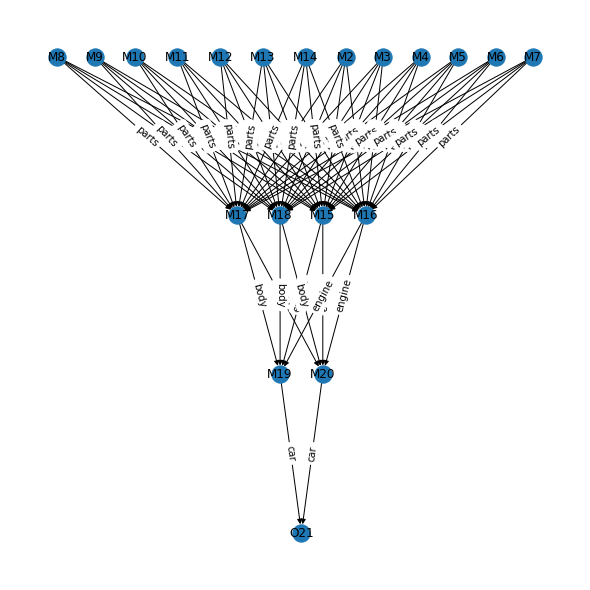

In [25]:
factory.print_factory()

In [26]:
factory.run_agents()
#app.run_server(debug=False, port=8050)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


MachineAgent started at 17:15:39.092019
MachineAgent started at 17:15:39.095403
MachineAgent started at 17:15:39.099354
MachineAgent started at 17:15:39.165350
MachineAgent started at 17:15:39.165919
OrderAgent started at 17:15:39.166923
MaintenanceAgent started at 17:15:39.168090
MachineAgent started at 17:15:39.168636
MachineAgent started at 17:15:39.168839
MachineAgent started at 17:15:39.169027
MachineAgent started at 17:15:39.169224
MachineAgent started at 17:15:39.169411
MachineAgent started at 17:15:39.169599
MachineAgent started at 17:15:39.169784
MachineAgent started at 17:15:39.170080
MachineAgent started at 17:15:39.179424
MachineAgent started at 17:15:39.179773
MachineAgent started at 17:15:39.179902
MachineAgent started at 17:15:39.180014
MachineAgent started at 17:15:39.181046
MachineAgent started at 17:15:39.181189
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@loc

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 pleas

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
no engine now
no engine now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please par

Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
Message received with content: {"item": "parts", "payment": "205"}
sending cash
Message received with content: {"item": "parts", "payment": "200"}
Message received with content: {"item": "parts", "payment": "200"}
Message received with content: {"item": "parts", "payment": "200"}
Message received with content: {"item": "parts", "payment": "200"}
Message received with content: {"item": "parts", 

no parts now
no parts now
no parts now
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
Lowering price from 176 to 172
proposing
no engine now
no engine now
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
no parts now
no parts now
no parts now
no parts now
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
Message received with

Lowering price from 221 to 216
proposing
Lowering price from 205 to 200
proposing
Lowering price from 257 to 251
proposing
Lowering price from 237 to 232
proposing
Lowering price from 193 to 189
proposing
Lowering price from 185 to 181
proposing
Lowering price from 176 to 172
proposing
Lowering price from 172 to 168
proposing
Lowering price from 172 to 168
proposing
Lowering price from 171 to 167
proposing
Lowering price from 156 to 152
proposing
Lowering price from 156 to 152
proposing
Lowering price from 156 to 152
proposing
Message received with content: {"item": "parts", "payment": "216"}
Message received with content: {"item": "parts", "payment": "200"}
Message received with content: {"item": "parts", "payment": "251"}
Message received with content: {"item": "parts", "payment": "232"}
Message received with content: {"item": "parts", "payment": "189"}
Message received with content: {"item": "parts", "payment": "181"}
Message received with content: {"item": "parts", "payment": "172"

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 196 to 192
proposing
Lowering price from 184 to 180
proposing
Lowering price from 230 to 225
proposing
Lowering price from 212 to 207
proposing
Lowering price from 173 to 169
proposing
Lowering price from 165 to 161
proposing
Lowering price from 156 to 152
proposing
Lowering price from 152 to 148
proposing
Lowering price from 152 to 148
proposing
Lowering price from 151 to 147
proposing
Lowering price from 151 to 147
proposing
no parts now
Lowering price from 151 to 147
proposing
Message received with content: {"item": "parts", "payment": "192"}
Message received with content: {"

user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 431 to 422
proposing
Message received with content: {"item": "body", "payment": "422"}
sending cash
Upping price from 422 to 464
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 176 to 172
proposing
Lowering price from 164 to 160
proposing
Lowering price from 205 to 200
proposing
Lowering price from 189 to 185
proposing
Lowering price from 153 to 149
proposing
Lowering price from 146 to 143
proposing
Lo

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 454 to 444
proposing
no engine now
Lowering price from 160 to 156
proposing
Lowering price from 148 to 145
proposing
Lowering price from 188 to 184
proposing
Lowering price from 173 to 169
proposing
Lowering price from 140 to 137
proposing
Lowering price from 161 to 157
proposing
Lowering price from 140 to 137
proposing
Lowering price from 136 to 133
proposing
Lowering price from 137 to 134
proposing
Lowering price from 147 to 144
proposing
Lowering price from 135 to 132
proposing
Lowering price from 165 to 161
prop

user@localhost/15 please engine
user@localhost/16 please engine
no engine now
Lowering price from 464 to 454
proposing
Message received with content: {"item": "engine", "payment": "454"}
sending cash
Upping price from 454 to 499
sending product
thank you user@localhost/16
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 145 to 142
proposing
Lowering price from 136 to 133
proposing
Lowering price from 172 to 168
proposing
Lowering price from 157 to 153
proposing
Lowering price from 128 to 125
proposing
Lowering price from 146 to 143
proposing
Lowering price from 128 to 125
proposing
Lowering price from 136 to 133
proposing
Lowe

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 133 to 130
proposing
Lowering price from 124 to 121
proposing
Lowering price from 156 to 152
proposing
Lowering price from 143 to 140
proposing
Lowering price from 128 to 125
proposing
Lowering price from 134 to 131
proposing
Lowering price from 140 to 137
proposing
Lowering price from 124 to 121
proposing
Lowering price from 125 to 122
proposing
Lowering price from 135 to 132
proposing
Lowering price from 124 to 121
proposing
Lowering price from 137 to 134
proposing
Lowering price from 123 to 120
proposing
Message received with content: {"item": "parts", "payment": "130"}
Messa

127.0.0.1 - - [29/Jun/2022 17:15:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_4_1m1653499004.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/deps/react@16.v2_4_1m1653499004.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_4_1m1653499004.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_4_1m1653499004.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_1_0m1655123508.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_4_1m1653499004.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/dash_table/bundle.


Message received with content: {"item": "parts", "payment": "120"}
Message received with content: {"item": "parts", "payment": "139"}
Message received with content: {"item": "parts", "payment": "128"}
Message received with content: {"item": "parts", "payment": "113"}
Message received with content: {"item": "parts", "payment": "119"}
Message received with content: {"item": "parts", "payment": "125"}
Message received with content: {"item": "parts", "payment": "132"}
Message received with content: {"item": "parts", "payment": "110"}
Message received with content: {"item": "parts", "payment": "120"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "122"}
Message received with content: {"item": "parts", "payment": "120"}
sending cash
Upping price from 109 to 119
sending product
thank you user@localhost/12
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
Lowering price from 499 to 489


127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_favicon.ico?v=2.4.1 HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:50] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 112 to 109
proposing
Lowering price from 114 to 111
proposing
Lowering price from 133 to 130
proposing
Lowering price from 122 to 119
proposing
Lowering price from 107 to 104
proposing
Lowering price from 113 to 110
proposing
Lowering price from 119 to 116
proposing
Lowering price from 126 to 123
proposing
Lowering price from 125 to 122
proposing
Lowering price from 114 to 111
proposing
Lowering price from 113 to 110
proposing
Lowering price from 116 to 113
proposing
Lowering price from 114 to 111
proposing
Message received with content: {"item": "parts", "payment": "109"}
Messa

127.0.0.1 - - [29/Jun/2022 17:15:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
no engine now
no engine now
Lowering price from 2276 to 2230
proposing
Lowering price from 2275 to 2229
proposing
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "car", "payment": "2230"}
Message received with content: {"item": "car", "payment": "2229"}
sending cash 2229
no body now
no body now
Upping price from 2229 to 2451
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 525 to 514
proposing
no engine now
Message received with content: {"item": "engine", "payment": "514"}
sending cash
Upping price from 514 to 565
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 537 to 526
proposing
no body now
Message received with content: {"item": "body", "payment": "526"}
sen

127.0.0.1 - - [29/Jun/2022 17:15:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts

127.0.0.1 - - [29/Jun/2022 17:15:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:52] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
Lowering price from 537 to 526
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 118 to 115
proposing
Lowering price from 107 to 104
proposing
Lowering price from 102 to 99
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 111 to 108
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "526"}
sending cash
Upping price from 526 to 578
sending product
thank you user@localhost/16
user@localhost/17

127.0.0.1 - - [29/Jun/2022 17:15:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:15:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 106 to 103
proposing
Lowering price from 110 to 107
proposing
Lowering price from 106 to 103
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 107 to 104
proposin

127.0.0.1 - - [29/Jun/2022 17:15:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposin

127.0.0.1 - - [29/Jun/2022 17:15:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:54] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no body now
no body now
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "p

127.0.0.1 - - [29/Jun/2022 17:15:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 608 to 595
proposing
no engine now
Lowering price from 2354 to 2306
proposing
Lowering price from 2587 to 2535
proposing
Message received with content: {"item": "engine", "payment": "595"}
sending cash
Message received with content: {"item": "car", "payment": "2306"}
Message received with content: {"item": "car", "payment": "2535"}
sending cash 2306
Upping price from 595 to 654
sending product
Upping price from 2306 to 2536
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
thank you user@localhost/19
Lowering price from 622 to 609
proposing
no body now
Message received with content: {"item": "body", "payment": "609"}
sending cash
Upping price from 609 to 669
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
use

127.0.0.1 - - [29/Jun/2022 17:15:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 622 to 609
proposing
Message received with content: {"item": "body", "payment": "609"}
sending cash
Upping price from 609 to 669
sending product
thank you user@localhost/18
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts


127.0.0.1 - - [29/Jun/2022 17:15:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
no engine now
Lowering price from 106 to 103
proposing
Lowering price from 110 to 107
proposing
Lowering price from 115 to 112
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "112"}
Message received with content: {"item": "parts", "payment": "1

127.0.0.1 - - [29/Jun/2022 17:15:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
no engine now
Lowering price from 622 to 609
proposing
Lowering price from 103 to 100
proposing
Lowering price from 107 to 104
proposing
Lowering price from 112 to 109
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:15:56] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:15:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:56] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"ite

127.0.0.1 - - [29/Jun/2022 17:15:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 2485 to 2435
proposing
Lowering price from 2732 to 2677
proposing
Message received with content: {"item": "car", "payment": "2435"}
Message received with content: {"item": "car", "payment": "2677"}
sending cash 2435
Upping price from 2435 to 2678
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
no engine now
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 1

127.0.0.1 - - [29/Jun/2022 17:15:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:15:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 704 to 689
proposing
no engine now
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "paymen

127.0.0.1 - - [29/Jun/2022 17:15:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 2678 to 2624
proposing
Lowering price from 2677 to 2623
proposing
Message received with content: {"item": "car", "payment": "2624"}
Message received with content: {"item": "car", "payment": "2623"}
sending cash 2623
Upping price from 2623 to 2885
sending product
thank you user@localhost/20
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please pa

127.0.0.1 - - [29/Jun/2022 17:15:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
no engine now
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98

127.0.0.1 - - [29/Jun/2022 17:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:15:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:15:59] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message 

127.0.0.1 - - [29/Jun/2022 17:15:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 2828 to 2771
proposing
Lowering price from 2827 to 2770
proposing
Message received with content: {"item": "car", "payment": "2771"}
Message received with content: {"item": "car", "payment": "2770"}
sending cash 2770
Upping price from 2770 to 3047
sending product
thank you user@localhost/20
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:16:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:00] "POST /_dash-update-component HTTP/1.1" 200 -


no engine now
no engine now
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content:

127.0.0.1 - - [29/Jun/2022 17:16:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 815 to 798
proposing
no engine now
Message received with content: {"item": "engine", "payment": "798"}
sending cash
Upping price from 798 to 877
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 834 to 817
proposing
no body now
Message received with content: {"item": "body", "payment": "817"}
sending cash
Upping price from 817 to 898
sending product
thank you user@localhost/17
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 2771 to 2715
proposing
Lowering price from 3047 to 2986
proposing
Message received with content: {"item": "car", "payment": "2715"}
Message received with content: {"item": "car", "payment": "2986"}
sending cash 2715
Upping price from 2715 to 2986
sending product
thank you user@localhost/19
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
use

127.0.0.1 - - [29/Jun/2022 17:16:01] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/2 pl

127.0.0.1 - - [29/Jun/2022 17:16:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:01] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 834 to 817
proposing
Message received with content: {"item": "body", "payment": "817"}
sending cash
Upping price from 817 to 898
sending product
thank you user@localhost/18
Message received with co

127.0.0.1 - - [29/Jun/2022 17:16:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
Lowering price from 834 to 817
proposing
Message received with content: {"item": "engine", "payment": "817"}
sending cash
Upping price from 817 to 898
sending product
thank you user@localhost/16
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:16:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 877 to 859
proposing
no engine now
Message received with content: {"item": "engine", "payment": "859"}
sending cash
Upping price from 859 to 944
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 898 to 880
proposing
no body now
Message received with content: {"item": "body", "payment": "880"}
sending cash
Upping price from 880 to 968
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts

127.0.0.1 - - [29/Jun/2022 17:16:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:02] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering 

127.0.0.1 - - [29/Jun/2022 17:16:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowerin

no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100

127.0.0.1 - - [29/Jun/2022 17:16:03] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now


127.0.0.1 - - [29/Jun/2022 17:16:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body


127.0.0.1 - - [29/Jun/2022 17:16:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/18 please body
no body now
no body now
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3153 to 3089
proposing
Lowering price from 3153 to 3089
proposing
Message received with content: {"item": "car", "payment": "3089"}
Message received with content: {"item": "car", "payment": "3089"}
sending cash 3089
Upping price from 3089 to 3397
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 944 to 925
proposing
no engine now
Message received with content: {"item": "engine", "payment": "925"}
sending cash
Upping price from 925 to 1017
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 968 to 948
proposing
no body now
Message received with content: {"item": "body", "payment": "948"}
sending cash
Upping price from 948 to 1042
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@lo

127.0.0.1 - - [29/Jun/2022 17:16:04] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
no engine now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 1

127.0.0.1 - - [29/Jun/2022 17:16:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:04] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
Upping price from 100 to 110
sending produc

127.0.0.1 - - [29/Jun/2022 17:16:04] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3397 to 3329
proposing
Lowering price from 3089 to 3027
proposing
Message received with content: {"item": "car", "payment": "3329"}
Message received with content: {"item": "car", "payment": "3027"}
sending cash 3027
Upping price from 3027 to 3329
sending product
thank you user@localhost/20
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Messag

127.0.0.1 - - [29/Jun/2022 17:16:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now


127.0.0.1 - - [29/Jun/2022 17:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1017 to 996
proposing
no engine now
Message received with content: {"item": "engine", "payment": "996"}
sending cash
Upping price from 996 to 1095
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1042 to 1021
proposing
no body now
Message received with content: {"item": "body", "payment": "1021"}
sending cash
Upping price from 1021 to 1123
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@lo

user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to

127.0.0.1 - - [29/Jun/2022 17:16:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 1042 to 1021
proposing
Message received with content: {"item": "body", "payment": "1021"}
sending cash
Upping price from 1021 to 1123
sending product
thank you user@loca

127.0.0.1 - - [29/Jun/2022 17:16:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 109 to 106
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 t

127.0.0.1 - - [29/Jun/2022 17:16:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "

127.0.0.1 - - [29/Jun/2022 17:16:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:07] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 103 to 100
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:16:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 plea

127.0.0.1 - - [29/Jun/2022 17:16:08] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 104 to 101
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "118"}
Mes

127.0.0.1 - - [29/Jun/2022 17:16:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:08] "POST /_dash-update-component HTTP/1.1" 200 -


no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine


127.0.0.1 - - [29/Jun/2022 17:16:08] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 1180 to 1156
proposing
no engine now
Message received with content: {"item": "engine", "payment": "1156"}
sending cash
Upping price from 1156 to 1271
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100

127.0.0.1 - - [29/Jun/2022 17:16:09] "POST /_dash-update-component HTTP/1.1" 200 -


no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 104 to 101
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "paymen

127.0.0.1 - - [29/Jun/2022 17:16:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:09] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/4
Message received with content: {"item": "body", "payment": "1185"}
sending cash
Upping price from 1185 to 1303
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 1

127.0.0.1 - - [29/Jun/2022 17:16:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:09] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:16:10] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1271 to 1245
proposing
no engine now
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
L

127.0.0.1 - - [29/Jun/2022 17:16:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:10] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "1276"}
sending cash
Upping price from 1276 to 1403
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:16:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:10] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no engine now
Lowe

127.0.0.1 - - [29/Jun/2022 17:16:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1369 to 1341
proposing
no engine now
Message received with content: {"item": "engine", "payment": "1341"}
sending cash
Upping price from 1341 to 1475
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to

127.0.0.1 - - [29/Jun/2022 17:16:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no body now
Lowering price from 1403 to 1374
proposing
Message received with content: {"item": "body", "payment": "1374"}
sending cash
Upping price from 1374 to 1511
sending product
thank you user@loc

127.0.0.1 - - [29/Jun/2022 17:16:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:12] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/3
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 plea

127.0.0.1 - - [29/Jun/2022 17:16:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1475 to 1445
proposing
no engine now
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing


127.0.0.1 - - [29/Jun/2022 17:16:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:13] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "1445"}
se

127.0.0.1 - - [29/Jun/2022 17:16:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
Lowering price from 1511 to 1480
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering 

127.0.0.1 - - [29/Jun/2022 17:16:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:14] "POST /_dash-update-component HTTP/1.1" 200 -



no parts now
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message 

127.0.0.1 - - [29/Jun/2022 17:16:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4058 to 3976
proposing
Lowering price from 4057 to 3975
proposing
Message received with content: {"item": "car", "payment": "3976"}
Message received with content: {"item": "car", "payment": "3975"}
sending cash 3975
Upping price from 3975 to 4372
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1589 to 1557
proposing
no engine now
Message received with content: {"item": "engine", "payment": "1557"}
sending cash
Upping price from 1557 to 1712
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
use

127.0.0.1 - - [29/Jun/2022 17:16:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:15] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "112"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please part

127.0.0.1 - - [29/Jun/2022 17:16:15] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "payment": "1595"}
sending cash
Upping price from 1595 to 1754
sending product
thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "part

127.0.0.1 - - [29/Jun/2022 17:16:15] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
no parts now
Lowering price from 103 to 100
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
M

127.0.0.1 - - [29/Jun/2022 17:16:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1712 to 1677
proposing
no engine now
Message received with content: {"item": "engine", "payment": "1677"}
sending cash
Upping price from 1677 to 1844
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:16:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:17] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/14 please parts
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no body now
Lowering price from 1683 to 1649
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:16:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price fr

127.0.0.1 - - [29/Jun/2022 17:16:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Mes

127.0.0.1 - - [29/Jun/2022 17:16:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1851 to 1813
proposing
Lowering price from 1813 to 1776
proposing
Message received with content: {"item": "body", "payment": "1813"}
Message received with content: {"item": "body", "payment": "1776"}
sending cash
Upping price from 1776 to 1953
sending product
thank you user@localhost/18
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1813 to 1776
proposing
no body now
Message received with content: {"item": "body", "payment": "1776"}
sending cash
U

127.0.0.1 - - [29/Jun/2022 17:16:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:19] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
user@localhost/2 please parts
user@localhost/3 please part

127.0.0.1 - - [29/Jun/2022 17:16:19] "POST /_dash-update-component HTTP/1.1" 200 -


Upping price from 110 to 121
sending product
thank you user@localhost/2
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4032 to 3951
proposing
Lowering price from 4031 to 3950
proposing
Message received with content: {"item": "car", "payment": "3951"}
Message received with content: {"item": "car", "payment": "3950"}
sending cash 3950
Upping price from 3950 to 4345
sending product
thank you user@localhost/20


127.0.0.1 - - [29/Jun/2022 17:16:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1987 to 1947
proposing
no engine now
Message received with content: {"item": "engine", "payment": "1947"}
sending cash
Upping price from 1947 to 2141
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine

127.0.0.1 - - [29/Jun/2022 17:16:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:20] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
no engine now
no engine now
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
no body now
no body now
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1953 to 1913
proposing
Lowering price from 1953 to 1913
proposing
Message received with content: {"item": "body", "payment": "1913"}
Message received with content: {"item": "body", "payment": "1913"}
sending cash
Upping price from 1913 to 2104
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 1913 to 1874
proposing
Message received with content: {"item": "body", "payment": "1874"}
sending cash
Upping price from 1874 to 2061
sending product
thank you user@localhost/18
user@local

127.0.0.1 - - [29/Jun/2022 17:16:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 106 to 103
proposing
Lowering price from 112 to 109
proposing
no parts now
Lowering price from 108 to 105
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 pl

127.0.0.1 - - [29/Jun/2022 17:16:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 102 to 99
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 103 to 100
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from

127.0.0.1 - - [29/Jun/2022 17:16:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4258 to 4172
proposing
Lowering price from 4258 to 4172
proposing
Message received with content: {"item": "car", "payment": "4172"}
Message received with content: {"item": "car", "payment": "4172"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 2141 to 2098
proposing
no engine now
Message received with content: {"item": "engine", "payment": "2098"}
sending cash
Upping price from 2098 to 2307
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2104 to 2061
proposing
Lowering price from 2061 to 2019
proposing
Message received with content: {"item": "body", "payment": "2061"}
Message received with content: {"item": "body", "payment": "2019"}
sending cash
Upping price from 2019 to 2220
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 p

127.0.0.1 - - [29/Jun/2022 17:16:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:22] "POST /_dash-update-component HTTP/1.1" 200 -



sending cash
Upping price from 2019 to 2220
sending product
thank you user@localhost/17
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with conte

127.0.0.1 - - [29/Jun/2022 17:16:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:16:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:16:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:23] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 2260 to 2214
proposing
no engine now
Message received with content: {"item": "engine", "payment": "2214"}
sending cash
Upping price from 2214 to 2435
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4088 to 4006
proposing
Lowering price from 4088 to 4006
proposing
Message received with content: {"item": "car", "payment": "4006"}
Message received with content: {"item": "car", "payment": "4006"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2220 to 2175
proposing
Lowering price from 2220 to 2175
proposing
Message received with content: {"item": "body", "payment": "2175"}
Message received with content: {"item": "body", "payment": "2175"}
sending cash
Upping price from 2175 to 2392
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@local

127.0.0.1 - - [29/Jun/2022 17:16:24] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no engine now
no engine now
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:16:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:24] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 2435 

127.0.0.1 - - [29/Jun/2022 17:16:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:24] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 p

127.0.0.1 - - [29/Jun/2022 17:16:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 2386 to 2338
proposing
no engine now
Message received with content: {"item": "engine", "payment": "2338"}
sending cash
Upping price from 2338 to 2571
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
no body now
no body now
user@localhost/17 please body
user@localhost/18 please body
no body now
no body now


127.0.0.1 - - [29/Jun/2022 17:16:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2392 to 2344
proposing
Lowering price from 2344 to 2297
proposing
Message received with content: {"item": "body", "payment": "2344"}
Message received with content: {"item": "body", "payment": "2297"}
user@localhost/15 please engine
user@localhost/16 please engine
no engine now
no engine now
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2344 to 2297
proposing
Lowering price from 2297 to 2251
proposing
Message received with content: {"item": "body", "payment": "2297"}
Message received with content: {"item": "body", "payment": "2251"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2297 to 2251
proposing
Lowering price from 2251 to 2205
proposing
Message received with content: {"item": "body", "payment": "2251"}
Message received with content: {"item": "body", "payment": "2205"}
user@localhost/2 please parts
user@localhost/3 please parts
user@loc

127.0.0.1 - - [29/Jun/2022 17:16:26] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 2073 to 2031
proposing
no body now
Message received with content: {"item": "body", "payment": "2031"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:16:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 103 to 100
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:16:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1990 to 1950
proposing
no body now
Message received with content: {"item": "body", "payment": "1950"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1950 to 1911
proposing
no body now
Message received with content: {"item": "body", "payment": "1911"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1911 to 1872
proposing
no body now
Message received with content: {"item": "body", "payment": "1872"}
user@localhost/19 please car
user@localhost/20 please car
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 4230 to 4145
proposing
Lowering price from 4230 to 4145
proposing
Lowering price from 1872 to 1834
proposing
no body now
Message received with content: {"item": "car", "payment": "4145"}
Message received with content: {"item": "car", "payment": "4145"}
Message received with content: {"item": "body", "payment": "183

127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1761 to 1725
proposing
Lowering price from 2189 to 2145
proposing
Message received with content: {"item": "body", "payment": "1725"}
Message received with content: {"item": "body", "payment": "2145"}
sending cash
Upping price from 1725 to 1897
sending product
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 plea

127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please pa

127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:27] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 112 to 109
proposing
Lowering price from 118 to 115
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "2369"}
Message received with content: {"item": "engine", "payment": "2637"}
user@localhost/17 please body
user@localhost/18 please body
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 109 to 106
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 1859 to 1821
proposing
Lowering price from 2102 to 2059
proposing
Lowering price from 4145 to 4062
proposing
Lowering price from 4145 to 4062
proposing
Lowering price from 106 to 103
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", 

127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:28] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 2321 to 2274
proposing
Lowering price from 2584 to 2532
proposing
Message received with content: {"item": "engine", "payment": "2274"}
Message received with content: {"item": "engine", "payment": "2532"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1784 to 1748
proposing
Lowering price from 2017 to 1976
proposing
Message received with content: {"item": "body", "payment": "1748"}
Message received with content: {"item": "body", "payment": "1976"}
Message received with content: {"item": "parts", "payment": "100"}
Messag

127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 2054 to 2012
proposing
Lowering price from 2287 to 2241
proposing
Message received with content: {"item": "engine", "payment": "2012"}
Message received with content: {"item": "engine", "payment": "2241"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1578 to 1546
proposing
Lowering price from 1784 to 1748
proposing
Message received with content: {"item": "body", "payment": "1546"}
Message received with content: {"item": "body", "payment": "1748"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 2012 to 1971
proposing
Lowering price from 2241 to 2196
proposing
Message received with content: {"item": "engine", "payment": "1971"}
Message received with content: {"item": "engine", "payment": "2196"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1546 to 1515
proposing
Lowering price from 1748 to 1713
proposin

127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "engine", "payment": "1892"}
Message received with content: {"item": "engine", "payment": "2108"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1484 to 1454
proposing
Lowering price from 1678 to 1644
proposing
Message received with content: {"item": "body", "payment": "1454"}
Message received with content: {"item": "body", "payment": "1644"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4062 to 3980
proposing
Lowering price from 4062 to 3980
proposing
Message received with content: {"item": "car", "payment": "3980"}
Message received with content: {"item": "car", "payment": "3980"}
sending cash 3980
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 3980 to 4378
sending product
Lowering price from 1892 to 1854
proposing
Lowering price from 2108 to 2065
proposing
thank you user@localhost/19

127.0.0.1 - - [29/Jun/2022 17:16:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:30] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:16:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:30] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 1803 to 1766
proposing
Lowering price from 1826 to 1789
proposing
Lowering price from 4378 to 4290
proposing
Lowering price from 3980 to 3900
proposing
Message received with content: {"item": "engine", "payment": "1766"}
Message received with content: {"item": "engine", "payment": "1789"}
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "car", "payment": "4290"}
Message rec

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1826 to 1789
proposing
Lowering price from 1682 to 1648
proposing
Message received with content: {"item": "engine", "payment": "1789"}
Message received with content: {"item": "engine", "payment": "1648"}
user@localhost/17 please body
user@localhost/18 please body
no body now
Lowering price from 1339 to 1312
proposing
Message received with content: {"item": "body", "payment": "1312"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1789 to 1753
proposing
Lowering price from 1648 to 1615
proposing
Message received with content: {"item": "engine", "payment": "1753"}
Message received with content: {"item": "engine", "payment": "1615"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1522 to 1491
proposing
Lowering price from 1312 to 1285
proposing
Message received with content: {"item": "body", "payment": "1491"}
Message received with content

127.0.0.1 - - [29/Jun/2022 17:16:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1753 to 1717
proposing
Lowering price from 1615 to 1582
proposing
Message received with content: {"item": "engine", "payment": "1717"}
Message received with content: {"item": "engine", "payment": "1582"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1491 to 1461
proposing
Lowering price from 1285 to 1259
proposing
Message received with content: {"item": "body", "payment": "1461"}
Message received with content: {"item": "body", "payment": "1259"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@

127.0.0.1 - - [29/Jun/2022 17:16:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:31] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:16:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1648 to 1615
proposing
Lowering price from 1519 to 1488
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pric

127.0.0.1 - - [29/Jun/2022 17:16:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1458 to 1428
proposing
Lowering price from 1343 to 1316
propos

127.0.0.1 - - [29/Jun/2022 17:16:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:32] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
Upping price from 110 to 121
sending product
thank you user@localhost/5
thank you user@localhost/5
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1399 to 1371
proposing
Lowering price from 1289 to 1263
proposing
Lowering price from 1371 to 1343
proposing
Lowering price from 1263 to 1237
proposing
Message received with content: {"item": "engine", "payment": "1371"}
Message received with content: {"item": "engine", "payment": "1263"}
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "engine", "payment": "1343"}
Message received with content: {"item": "engine", "payment": "1237"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1189 to 1165
proposing
Lowering price from 1024 to 1003
proposing
Lowering price from 1165 to 1141
proposing
Lowering price from 1003 to 982
proposing
Message received w

127.0.0.1 - - [29/Jun/2022 17:16:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4204 to 4119
proposing
Lowering price from 4204 to 4119
proposing
Message received with content: {"item": "car", "payment": "4119"}
Message received with content: {"item": "car", "payment": "4119"}
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1343 to 1316
proposing
Lowering price from 1237 to 1212
proposing
Lowering price from 1316 to 1289
proposing
Lowering price from 1212 to 1187
proposing
Message received with content: {"item": "engine", "payment": "1316"}
Message received with content: {"item": "engine", "payment": "1212"}
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "engine", "payment": "1289"}
Message received with content: {"item": "engine", "payment": "1187"}
Lowering price from 1141 to 1118
proposing
Lowering price from 1080 to 1058
proposing
Me

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1139 to 1116
proposing
Lowering price from 1049 to 1028
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1116 to 1093
proposing
Lowering price from 1028 to 1007
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering p

127.0.0.1 - - [29/Jun/2022 17:16:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:33] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "1071"}
Message received with content: {"item": "engine", "payment": "986"}
Message received with content: {"item": "engine", "payment": "1049"}
Message received with content: {"item": "engine", "payment": "966"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1029 to 1008
proposing
Lowering price from 974 to 954
proposing
Message received with content: {"item": "body", "payment": "1008"}
Message received with 

127.0.0.1 - - [29/Jun/2022 17:16:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 1049 to 1028
proposing
Lowering price from 966 to 946
proposing
Lowering price from 4119 to 4036
proposing
Lowering price from 4119 to 4036
proposing
Lowering price from 1028 to 1007
proposing
Lowering price from 946 to 927
proposing
Message received with content: {"item": "engine", "payment": "1028"}
Message received with content: {"item": "engine", "payment": "946"}
Message received with content: {"item": "car", "payment": "4036"}
Message received with content: {"item": "car", "payment": "4036"}
Message received with content: {"item": "engine", "payment": "1007"}
Message received with content: {"item": "engine", "payment": "927"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 1008 to 987
proposing
Lowering price from 954 to 934
proposing
Message rec

user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}

127.0.0.1 - - [29/Jun/2022 17:16:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 835 to 818
proposing
Lowering price from 768 to 752
proposing
Message received with content: {"item": "engine", "payment": "818"}
Message received with content: {"item": "engine", "payment": "752"}
sending cash
Upping price from 752 to 827
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 909 to 890
proposing
Lowering price from 860 to 842
proposing
Message received with content: {"item": "body", "payment": "890"}
Message received with content: {"item": "body", "payment": "842"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 818 to 801
proposing
Lowering price from 827 to 810
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
us

127.0.0.1 - - [29/Jun/2022 17:16:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 890 to 872
proposing
Lowering price from 842 to 825
proposing
Message received with content: {"item": "body", "payment": "872"}
Message received with content: {"item": "body", "payment": "825"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 801 to 784
proposing
Lowering price from 810 to 793
proposing
Message received with content: {"item": "engine", "payment": "784"}
Message received with content: {"item": "engine", "payment": "793"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "p

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 736 to 721
proposing
Lowering price from 745 to 730
proposing
Message received with content: {"item": "engine", "payment": "721"}
Message received with content: {"item": "engine", "payment": "730"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing


127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 706 to 691
proposing
Lowering price from 715 to 700
proposing
Message received with content: {"item": "engine", "payment": "691"}
Message received with content: {"item": "engine", "payment": "700"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "pa

127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price fro

127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 663 to 649
proposing
Lowering price from 672 to 658
proposing
Message received with content: {"item": "engine", "payment": "649"}
Message received with content: {"item": "engine", "payment": "658"}
sending cash
Upping price from 649 to 713
sending product
thank you user@localhost/15
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pro

127.0.0.1 - - [29/Jun/2022 17:16:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"ite

127.0.0.1 - - [29/Jun/2022 17:16:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:16:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 pleas

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:16:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:16:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:38] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Message received with content: {"item": "engine", "payment": "777"}
Message received with content: {"item": "engine", "payment": "716"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 931 to 912
proposing
Lowering price from 968 to 948
proposing
Message received with content: {"item": "body", "payment": "912"}
Message received with content: {"item": "body", "payment": "948"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107

127.0.0.1 - - [29/Jun/2022 17:16:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 700 to 686
proposing
Lowering price from 644 to 631
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:16:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:39] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 822 to 805
proposing
Lowering price from 855 to 837
proposing
Lowering price from 686 to 672
proposing
Lowering price from 631 to 618
proposing
Message received with content: {"item": "body", "payment": "805"}
Message received with content: {"item": "body", "payment": "837"}
Message received with content: {"item": "engine", "payment": "672"}
Message received with content: {"item": "engine", "payment": "618"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 805 to 788
proposing
Lowering price from 837 to 820
proposing
Message received with content: {"item": "body", "payment": "788"}
Message received with content: {"item": "body", "payment": "820"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with conten

127.0.0.1 - - [29/Jun/2022 17:16:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 580 to 568
proposing
Lowering price from 586 to 574
proposing
Message received with content: {"item": "engine", "payment": "568"}
Message received with content: {"item": "engine", "payment": "574"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 765 to 749
proposing
Lowering price from 723 to 708
proposing
Message received with content: {"item": "body", "payment": "749"}
Message received with content: {"item": "body", "payment": "708"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:16:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:40] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 568 to 556
proposing
Lowering price from 574 to 562
proposing
Message received with content: {"item": "engine", "payment": "556"}
Message received with content: {"item": "engine", "payment": "562"}
user@l

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 586 to 574
proposing
Lowering price from 539 to 528
proposing
Message received with content: {"item": "engine", "payment": "574"}
Message received with content: {"item": "engine", "payment": "528"}
sending cash
Upping price from 528 to 580
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 704 to 689
proposing
Lowering price from 731 to 716
proposing
Message received with content: {"item": "body", "payment": "689"}
Message received with content: {"item": "body", "payment": "716"}
sending cash
Upping price from 689 to 757
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:16:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:16:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {

127.0.0.1 - - [29/Jun/2022 17:16:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:42] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "605"}
Message received with content: {"item": "engine", "payment": "556"}
sending cash
Upping price from 556 to 611
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 741 to 726
proposing
Lowering price from 771 to 755
proposing
Message received with content: {"item": "body", "payment": "726"}
Message received with content: {"item": "body", "payment": "755"}
sending cash
Upping price from 726 to 798
sending product
tha

127.0.0.1 - - [29/Jun/2022 17:16:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4151 to 4067
proposing
Lowering price from 4149 to 4066
proposing
Message received with content: {"item": "car", "payment": "4067"}
Message received with content: {"item": "car", "payment": "4066"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:16:43] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:16:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:43] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 592 to 651
sending product
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 798 to 782
pr

127.0.0.1 - - [29/Jun/2022 17:16:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:43] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4067 to 3985
proposing
Lowering price from 4066 to 3984
proposing
Message received with content: {"item": "car", "payment": "3985"}
Message received with content: {"item": "car", "payment": "3984"}
sending cash 3984
Upping price from 3984 to 4382
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 651 to 637
proposing
Lowering price from 598 to 586
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:16:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:16:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:44] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 672 to 658
proposing
Lowering price from 618 to 605
proposing
Message received with content: {"item": "engine", "payment": "658"}
Message received with content: {"item": "engine", "payment": "605"}
sending cash
Upping price from 605 to 665
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 808 to 791
proposing
Lowering price from 839 to 822
proposing
Message received with content: {"item": "body", "payment": "791"}
Message received with content: {"item": "body", "payment": "822"}
sending cash
Upping price from 791 to 870
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:16:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Mess

127.0.0.1 - - [29/Jun/2022 17:16:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4295 to 4209
proposing
Lowering price from 4294 to 4208
proposing
Message received with content: {"item": "car", "payment": "4209"}
Message received with content: {"item": "car", "payment": "4208"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:16:46] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {

127.0.0.1 - - [29/Jun/2022 17:16:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:46] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering 

127.0.0.1 - - [29/Jun/2022 17:16:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:46] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 

127.0.0.1 - - [29/Jun/2022 17:16:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:16:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 88

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 700 to 686
proposing
Lowering price from 662 to 648
proposing
Lowering price from 672 to 658
proposing
Lowering price from 618 to 605
proposing
Message received with content: {"item": "body", "payment": "686"}
Message received with content: {"item": "body", "payment": "648"}
Message received with content: {"item": "engine", "payment": "658"}
Message received with content: {"item": "engine", "payment": "605"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 686 to 672
proposing
Lowering price from 648 to 635
proposing
Message received with content: {"item": "body", "payment": "672"}
Message received with content: {"item": "body", "payment": "635"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 ple

127.0.0.1 - - [29/Jun/2022 17:16:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:48] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 644 to 631
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:16:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 631 to 618
proposing
Lowering price from 580 to 568
proposing
Message received with content: {"item": "engine", "payment": "618"}
Message received with content: {"item": "engine", "payment": "568"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 631 to 618
proposing
Lowering price from 656 to 642
proposing
Message received with content: {"item": "body", "payment": "618"}
Message received with content: {"item": "body", "payment": "642"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4041 to 3960
proposing
Lowering price from 4040 to 3959
proposing
Message received with content: {"item": "car", "payment": "3960"}
Message received with content: {"item": "car", "payment": "3959"}
sending cash 3959
Upping price from 3959 to 4354
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:16:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:16:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 605 to 592
proposing
Lowering price from 611 to 598
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Messa

127.0.0.1 - - [29/Jun/2022 17:16:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:50] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/2 please parts
user@localhost

127.0.0.1 - - [29/Jun/2022 17:16:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/20 please car
Upping price from 100 to 110
sending product
Lowering price from 4268 to 4182
proposing
Lowering price from 4266 to 4180
proposing
thank you user@localhost/7
Message received with content: {"item": "car", "payment": "4182"}
Message received with content: {"item": "car", "payment": "4180"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Low

127.0.0.1 - - [29/Jun/2022 17:16:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 673 to 659
proposing
Lowering price from 618 to 605
proposing
Message received with content: {"item": "engine", "payment": "659"}
Message received with content: {"item": "engine", "payment": "605"}
sending cash
Upping price from 605 to 665
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 672 to 658
proposing
Lowering price from 699 to 685
proposing
Message received with content: {"item": "body", "payment": "658"}
Message received with content: {"item": "body", "payment": "685"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localho

127.0.0.1 - - [29/Jun/2022 17:16:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:51] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 100 to 110
sending product
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 110 to 107
proposing
thank you user@localhost/4
Message received with content: {"item": "parts", "payment": "104"}
Me

127.0.0.1 - - [29/Jun/2022 17:16:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:52] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 659 to 645
proposing
Lowering price from 665 to 651
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowerin

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 680 to 666
proposing
Lowering price from 624 to 611
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:16:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "payment": "651"}
Message received with content: {"item": "body", "payment": "679"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
M

127.0.0.1 - - [29/Jun/2022 17:16:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:53] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 679 to 665
proposing
Message received with content: {"item": "body", "payment": "637"}
Message received with content: {"item": "body", "payment": "665"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 638 to 625
proposing
Lowering price from 586 to 574
proposing
Message received with content: {"item": "engine", "payment": "625"}
Message received with content: {"item": "engine", "payment": "574"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 637 to 624
proposing
Lowering price from 665 to 651
proposing
Message received with content: {"item": "body", "payment": "624"}
Message received with content: {"item": "body", "payment": "651"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 625 to 612
proposing
Lowering price from 574 to 562
proposing
Message received with content: {"item": "engine", "payment": "612"}
Message received with content: {"item": "engine", "paymen

127.0.0.1 - - [29/Jun/2022 17:16:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 551 to 539
proposing
Lowering price from 556 to 544
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pric

127.0.0.1 - - [29/Jun/2022 17:16:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 539 to 528
proposing
Lowering price from 544 to 533
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:16:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 544 to 533
proposing
Lowering price from 500 to 490
proposing
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:16:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:55] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/5
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with conte

127.0.0.1 - - [29/Jun/2022 17:16:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:16:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:56] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Upping price from 522 to 574
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 586 to 574
proposing
Lowering price from 556 to 544
proposing
Message received with content: {"item": "body", "payment": "574"}
Message received with content: {"item": "body", "payment": "544"}
sending cash
Upping price from 544 to 598
sending product
thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "1

127.0.0.1 - - [29/Jun/2022 17:16:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:56] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/4
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 574 to 562
proposing
Lowering price from 528 to 517
proposing
Message received with content: {"item": "engine", "payment": "562"}
Message received with content: {"item": "engine", "payment": "517"}
sending cash
Upping price from 517 to 568
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 574 to 562
proposing
Lowering price from 598 to 586
proposing
Message received with content: {"item": "body", "payment": "562"}
Message received with content: {"item": "body", "payment": "586"}
sending cash
Upping price from 562 to 618
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@

127.0.0.1 - - [29/Jun/2022 17:16:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:16:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:57] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item"

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 592 to 580
proposing
Lowering price from 618 to 605
proposing
Message received with content: {"item": "body", "payment": "580"}
Message received with content: {"item": "body", "payment": "605"}
sending cash
Upping price from 580 to 638
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:16:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:58] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:16:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:16:59] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item":

127.0.0.1 - - [29/Jun/2022 17:16:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 574 to 631
sending product
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/16
user@loc

127.0.0.1 - - [29/Jun/2022 17:16:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:16:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received

127.0.0.1 - - [29/Jun/2022 17:17:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 625 to 612
proposing
Lowering price from 631 to 618
proposing
Message received with content: {"item": "engine", "payment": "612"}
Message received with content: {"item": "engine", "payment": "618"}
sending cash
Upping price from 612 to 673
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 658 to 644
proposin

127.0.0.1 - - [29/Jun/2022 17:17:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 673 to 659
proposing
Lowering price from 618 to 605
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 106 to 103
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pric

127.0.0.1 - - [29/Jun/2022 17:17:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 659 to 645
proposing
Lowering price from 665 to 651
proposing
Message received with content: {"item": "engine", "payment": "645"}
Message received with content: {"item": "engine", "payment": "651"}
sending cash
Upping price from 645 to 709
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 694 to 680
proposing
Lowering price from 659 to 645
proposing
Message received with content: {"item": "body", "payment": "680"}
Message received with content: {"item": "body", "payment": "645"}
sending cash
Upping price from 645 to 709
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:17:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:17:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 100 to 110
sending product
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lower

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 702 to 687
proposing
Lowering price from 666 to 652
proposing
Message received with content: {"item": "body", "payment": "687"}
Message received with content: {"item": "body", "payment": "652"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4046 to 3965
proposing
Lowering price from 4044 to 3963
proposing
Message received with content: {"item": "car", "payment": "3965"}
Message received with content: {"item": "car", "payment": "3963"}
sending cash 3963
Upping price from 3963 to 4359
sending product
thank you user@localhost/20
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please

127.0.0.1 - - [29/Jun/2022 17:17:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 673 to 659
proposing
Lowering price from 638 to 625
proposing
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:17:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:03] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/18 please body
Lowering price from 645 to 632
proposing
Lowering price from 673 to 659
proposing
Message received with content: {"item": "body", "payment": "632"}
Message received with content: {"item": "body", "payment": "659"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 632 to 619
proposing
Lowering price from 659 to 645
proposing
Message received with content: {"item": "body", "payment": "619"}
Message received with content: {"item": "body", "payment": "645"}


127.0.0.1 - - [29/Jun/2022 17:17:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 619 to 606
proposing
Lowering price from 645 to 632
proposing
Message received with content: {"item": "body", "payment": "606"}
Message received with content: {"item": "body", "payment": "632"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 606 to 593
proposing
Lowering price from 632 to 619
proposing
Message received with content: {"item": "body", "payment": "593"}
Message received with content: {"item": "body", "payment": "619"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price f

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 569 to 557
proposing
Lowering price from 593 to 581
proposing
Message received with content: {"item": "body", "payment": "557"}
Message received with content: {"item": "body", "payment": "581"}
sending cash
Upping price from 557 to 612
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@

127.0.0.1 - - [29/Jun/2022 17:17:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:04] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
Lowering price from 103 to 100
proposing
no parts now
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 733 to 718
proposing
Lowering price from 739 to 724
p

127.0.0.1 - - [29/Jun/2022 17:17:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 789 to 773
proposing
Lowering price from 724 to 709
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 115 to 112
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:17:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:05] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please part

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 773 to 757
proposing
Lowering price from 779 to 763
proposing
Message received with content: {"item": "engine", "payment": "757"}
Message received with content: {"item": "engine", "payment": "763"}
sending cash
Upping price from 757 to 832
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 645 to 632
proposing
Lowering price from 612 to 599
proposing
Message received with content: {"item": "body", "payment": "632"}
Message received with content: {"item": "body", "payment": "599"}
sending cash
Upping price from 599 to 658
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:17:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 832 to 815
proposing
Lowering price from 763 to 747
proposing
Message received with content: {"item": "engine", "payment": "815"}
Message received with content: {"item": "engine", "payment": "747"}
sending cash
Upping price from 747 to 821
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 632 to 619
proposing
Lowering price from 658 to 644
proposing
Message received with content: {"item": "body", "payment": "619"}
Message received with content: {"item": "body", "payment": "644"}
sending cash
Upping price from 619 to 680
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:17:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:07] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "payment": "638"}
Message received with content: {"item": "body", "payment": "605"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:17:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 766 to 750
proposing
Lowering price from 771 to 755
proposing
no parts now
no parts now
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with c

127.0.0.1 - - [29/Jun/2022 17:17:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:08] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 5

127.0.0.1 - - [29/Jun/2022 17:17:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:08] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 528 to 517
proposing
Lowering price from 550 to 539
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "payment": "517"}
Message received with content: {"item": "body", "payment": "539"}
Message received

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: 

127.0.0.1 - - [29/Jun/2022 17:17:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:09] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 522 to 511
proposing
Lowering price from 495 to 485
proposing
Message received with content: {"item": "body", "payment": "511"}
Message received with content: {"item": "body", "payment": "485"}
sending cash
Upping price from 485 to 533
sending product
thank you user@localhost/18


127.0.0.1 - - [29/Jun/2022 17:17:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:09] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:10] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "paym

127.0.0.1 - - [29/Jun/2022 17:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:10] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 768 to 844
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 107 to 104
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:17:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:11] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2


127.0.0.1 - - [29/Jun/2022 17:17:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 

no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "793"}
Message received with content: {"item": "engine", "payment": "798"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 568 to 556
proposing
Lowering price from 539 to 528
proposing
Message received with content: {"item": "body", "payment": "556"}
Message received with content: {"item": "body", "payment": "528"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "paym

127.0.0.1 - - [29/Jun/2022 17:17:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:17:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 522 to 511
proposing
Lowering price from 544 to 533
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 101 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:17:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
Lowering price from 836 to 819
proposing
Lowering price from 842 to 825
proposing
Message received with content: {"item": "engine", "payment": "819"}
Message received with content: {"item": "engine", "payment": "825"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@loca

127.0.0.1 - - [29/Jun/2022 17:17:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:17:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 900 to 882
proposing
Lowering price from 825 to 808
proposing
Message received with content: {"item": "engine", "payment": "882"}
Message received with content: {"item": "engine", "payment": "808"}
sending cash
Upping price from 808 to 888
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 550 to 539
proposing
Lowering price from 574 to 562
proposing
Message received with content: {"item": "body", "payment": "539"}
Message received with content: {"item": "body", "payment": "562"}
sending cash
Upping price from 539 to 592
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:17:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:15] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:17:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:15] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "p

127.0.0.1 - - [29/Jun/2022 17:17:16] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 100 to 110
sending product
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 912 to 893

127.0.0.1 - - [29/Jun/2022 17:17:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:16] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 893 to 875
proposing
Lowering price from 899 to 881
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowerin

sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/5
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 822 to 805
proposing
Lowering price from 828 to 811
proposing
Message received with content: {"item": "engine", "payment": "805"}
Message received with content: {"item": "engine", "payment": "811"}
user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 550 to 539
proposing
Lowering price from 522 to 511
proposing
Lowering price from 805 to 788
proposing
Lowering price from 811 to 794
proposing
Message received with content: {"item": "body", "payment": "539"}
Message received with content: {"item": "body", "payment": "511"}
Message received with content: {"item": "engine", "payment": "788"}
Message received with content: {"item": "engine", "payment": "794"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user

127.0.0.1 - - [29/Jun/2022 17:17:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 506 to 495
proposing
Lowering price from 528 to 517
proposing
Message received with content: {"item": "body", "payment": "495"}
Message received with content: {"item": "body", "payment": "517"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 495 to 485
proposing
Lowering price from 517 to 506
proposing

127.0.0.1 - - [29/Jun/2022 17:17:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:17] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "body", "payment": "485"}
Message received with content: {"item": "body", "payment": "506"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 

Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", 

127.0.0.1 - - [29/Jun/2022 17:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 848 to 831
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "p

127.0.0.1 - - [29/Jun/2022 17:17:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 118 to 115
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:17:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:17:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:17:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 944 to 925
proposing
Lowering price from 951 to 931
proposing
Message received with content: {"item": "engine", "payment": "925"}
Message received with content: {"item": "engine", "payment": "931"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 531 to 520
proposing
Lowering price from 504 to 493
proposing
Message received with content: {"item": "body", "payment": "520"}
Message received with content: {"item": "body", "payment": "493"}
sending cash
user@localhost/19 please car
user@localhost/20 please car
Upping price from 493 to 542
sending product
Lowering price from 4107 to 4024
proposing
Lowering price from 4105 to 4022
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
us

127.0.0.1 - - [29/Jun/2022 17:17:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:21] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 906 to 887
proposing
Lowering price from 912 to 893
pr

127.0.0.1 - - [29/Jun/2022 17:17:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 887 to 869
proposing
Lowering price from 893 to 875
proposing
Lowering price from 110 to 107
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:17:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:22] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 509 to 498
proposing
Lowering price from 531 to 520
proposing
Message received with content: {"item": "body", "payment": "498"}
Message received with content: {"item": "body", "payment": "520"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:17:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:22] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 520 to 509
proposing
Message received with content: {"item": "body", "payment": "488"}
Message received with content: {"item": "body", "payment": "509"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash


127.0.0.1 - - [29/Jun/2022 17:17:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3943 to 3864
proposing
Lowering price from 4335 to 4248
proposing
Message received with content: {"item": "car", "payment": "3864"}
Message received with content: {"item": "car", "payment": "4248"}
sending cash 3864
Upping price from 3864 to 4250
sending product
thank you user@localhost/19
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 439 to 430
proposing
Lowering price from 458 to 448
proposing
Message received with content: {"item": "body", "payment": "430"}
Message received with content: {"item": "body", "payment": "448"}
sending cash
Upping price from 430 to 473
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:17:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 843 to 826
proposing
Lowering price from 849 to 832
p

127.0.0.1 - - [29/Jun/2022 17:17:24] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 4250

127.0.0.1 - - [29/Jun/2022 17:17:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:24] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content

127.0.0.1 - - [29/Jun/2022 17:17:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:24] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 908 to 889
proposing
Lowering price from 832 to 815
proposing
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:17:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4165 to 4081
proposing
Lowering price from 4163 to 4079
proposing
Message received with content: {"item": "car", "payment": "4081"}
Message received with content: {"item": "car", "payment": "4079"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:17:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:17:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4081 to 3999
proposing
Lowering price from 4079 to 3997
proposing
Message received with content: {"item": "car", "payment": "3999"}
Message received with content: {"item": "car", "payment": "3997"}
sending cash 3997
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 3997 to 4396
sending product
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
propo

127.0.0.1 - - [29/Jun/2022 17:17:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:17:27] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "503"}
Message received with content: {"item": "body", "payment": "524"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:17:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:27] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/19 please car
user@localhost/20 please car
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 503 to 492
proposing
Lowering price from 524 to 513
proposing
Lowering price from 3999 to 3919
proposing
Lowering price from 4396 to 4308
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 t

127.0.0.1 - - [29/Jun/2022 17:17:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:27] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Messa

127.0.0.1 - - [29/Jun/2022 17:17:28] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:17:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:28] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Messag

127.0.0.1 - - [29/Jun/2022 17:17:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:28] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:17:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:17:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 4223 to 4138
proposing
Lowering price from 4221 to 4136
proposing
Message received with conte

127.0.0.1 - - [29/Jun/2022 17:17:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "1036"}
Message received with content: {"item": "engine", "payment": "1043"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 588 to 576
proposing
Lowering price from 557 to 545
proposing
Message received with content: {"item": "body", "payment": "576"}
Message received with content: {"item": "body", "payment": "545"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Me

127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "p

127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1015 to 994
proposing
Lowering price from 1022 to 1001
proposing
Message received with content: {"item": "engine", "payment": "994"}
Message received with content: {"item": "engine", "payment": "1001"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 564 to 552
proposing
Lowering price from 534 to 523
proposing
Message received with content: {"item": "body", "payment": "552"}
Message received with content: {"item": "body", "payment": "523"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts


127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 994 to 974
proposing
Lowering price from 1001 to 980
proposing
Message received with content: {"item": "engine", "payment": "974"}
Message received with content: {"item": "engine", "payment": "980"}
user@localhost/17 please body
user@l

127.0.0.1 - - [29/Jun/2022 17:17:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 974 to 954
proposing
Lowering price from 980 to 960
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:17:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 954 to 934
proposing
Lowering price from 960 to 940
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "954"}
Message received with content: {"item": "engine", "payment": "960"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 540 to 529
proposing
Lowering price from 512 to 501
proposing
Message received with 

127.0.0.1 - - [29/Jun/2022 17:17:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 896 to 878
proposing
Lowering price from 902 to 883
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:17:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 889 to 871
proposing
Lowering price from 813 to 796
proposing
Message received with content: {"item": "engine", "payment": "871"}
Message received with content: {"item": "engine", "payment": "796"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 9

127.0.0.1 - - [29/Jun/2022 17:17:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 853 to 835
proposing
Lowering price from 780 to 764
proposing
Message received with content: {"item": "engine", "payment": "835"}
Message received with content: {"item": "engine", "payment": "764"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 835 to 818
proposing
Lowering price from 764 to 748
proposing
Message received with content: {"item": "engine", "payment": "818"}
Message received with content: {"item": "engine", "payment": "748"}


127.0.0.1 - - [29/Jun/2022 17:17:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3973 to 3893
proposing
Lowering price from 4368 to 4280
proposing
Message received with content: {"item": "car", "payment": "3893"}
Message received with content: {"item": "car", "payment": "4280"}
sending cash 3893
Upping price from 3893 to 4282
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 818 to 801
proposing
Lowering price from 748 to 733
proposing
Message received with content: {"item": "engine", "payment": "801"}
Message received with content: {"item": "engine", "payment": "733"}
sending cash
Upping price from 733 to 806
sending product
thank you user@localhost/16
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 pleas

127.0.0.1 - - [29/Jun/2022 17:17:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 pl

127.0.0.1 - - [29/Jun/2022 17:17:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "par

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 844 to 827
proposing
Lowering price from 850 to 833
proposing
Message received with content: {"item": "engine", "payment": "827"}
Message received with content: {"item": "engine", "payment": "833"}
sending cash
Upping price from 827 to 909
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 575 to 563
proposing
Lowering price from 544 to 533
proposing
Message received with content: {"item": "body", "payment": "563"}
Message received with content: {"item": "body", "payment": "533"}
sending cash
Upping price from 533 to 586
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:17:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 p

127.0.0.1 - - [29/Jun/2022 17:17:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:34] "POST /_dash-update-component HTTP/1.1" 200 -



thank you user@localhost/9
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4196 to 4112
proposing
Lowering price from 4194 to 4110
proposing
Message received with content: {"item": "car", "payment": "4112"}
Message received with content: {"item": "car", "payment": "4110"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:17:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 909 to 890
proposing
Lowering price from 833 to 816
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:17:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:35] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 872 to 854
proposing
Lowering price from 879 to 861
proposing
Message received with content: {"item": "engine", "payment": "854"}
Message received with content: {"item": "engine", "payment": "861"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 593 to 581
proposing
Lowering price from 562 to 550
proposing
Message received with content: {"item": "body", "pa

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 802 to 785
proposing
Lowering price from 809 to 792
proposing
Message received with content: {"item": "engine", "payment": "785"}
Message received with content: {"item": "engine", "payment": "792"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 545 to 534
proposing
Lowering price from 517 to 506
proposing
Message received with content: {"item": "body", "payment": "534"}
Message received with content: {"item": "body", "payment": "506"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 pl

127.0.0.1 - - [29/Jun/2022 17:17:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:36] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 753 to 737
proposing
Lowering price from 760 to 744
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "737"}
Message received with content: {"item": "engine", 

127.0.0.1 - - [29/Jun/2022 17:17:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 722 to 707
proposing
Lowering price from 729 to 714
proposing
Message received with content: {"item": "engine", "payment": "707"}
Message received with content: {"item": "engine", "payment": "714"}
sending cash
Upping price from 707 to 777
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 490 to 480
proposing
Lowering price from 511 to 500
proposing
Message received with content: {"item": "body", "payment": "480"}
Message received with content: {"item": "body", "payment": "500"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 777 to 761
proposing
Lowering price from 714 to 699
proposing
Message received with content: {"item": "engine", "payment": "761"}
Message received with content: {"item": "engine", "payment": "699"}
sending cash
Upping price from 699 to 768
sending product
thank you user@loc

127.0.0.1 - - [29/Jun/2022 17:17:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 450 to 441
proposing
Lowering price from 470 to 460
proposing
Message received with content: {"item": "body", "payment": "441"}
Message received with content: {"item": "body", "payment": "460"}
user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts


127.0.0.1 - - [29/Jun/2022 17:17:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 441 to 432
proposing
Lowering price from 460 to 450
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content:

127.0.0.1 - - [29/Jun/2022 17:17:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 103 to 100
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content

127.0.0.1 - - [29/Jun/2022 17:17:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:17:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:39] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "785"}
Message received with content: {"item": "engine", "payment": "792"}
sending cash
Upping price from 785 to 863
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 479 to 469
proposing
Lowering price from 455 to 445
proposing
Message received with content: {"item": "body", "payment": "469"}
Message received with content: {"item": "body", "payment": "445"}
sending cash
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with cont

127.0.0.1 - - [29/Jun/2022 17:17:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received

127.0.0.1 - - [29/Jun/2022 17:17:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4169

127.0.0.1 - - [29/Jun/2022 17:17:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 863 to 845
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:17:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 778 to 762
proposing
Lowering price from 784 to 768
proposing
Message received with cont

127.0.0.1 - - [29/Jun/2022 17:17:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 746 to 731
proposing
Lowering price from 752 to 736
proposing
Message received with co

127.0.0.1 - - [29/Jun/2022 17:17:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 716 to 701
proposing
Lowering price from 721 to 706
pr

Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2


127.0.0.1 - - [29/Jun/2022 17:17:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:17:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:17:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:43] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/17
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/7


127.0.0.1 - - [29/Jun/2022 17:17:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:43] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
p

127.0.0.1 - - [29/Jun/2022 17:17:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 763 to 747
proposing
Lowering price from 768 to 752
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:17:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:44] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/7


127.0.0.1 - - [29/Jun/2022 17:17:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4142 to 4059
proposing
Lowering price from 4140 to 4057
proposing
Message received with content: {"item": "car", "payment": "4059"}
Message received with content: {"item": "car", "payment": "4057"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:17:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:17:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 804 to 787
proposing
Lowering price from 809 to 792
proposing
Lowering price from 4059 to 3977
proposing
Lowering price from 4057 to 3975
proposing
Message received with content: {"item": "engine", "payment": "787"}
Message received with content: {"item": "engine", "payment": "792"}
sending cash
Message received with content: {"item": "car", "payment": "3977"}
Message received with content: {"item": "car", "payment": "3975"}
sending cash 3975
Upping price from 787 to 865
sending product
Upping price from 3975 to 4372
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
thank you user@localhost/20
Lowering price from 565 to 553
proposing
Lowering price from 536 to 525
proposing
Message received with content: {"item": "body", "payment": "553"}
Message received with content: {"item": "body", "paymen

127.0.0.1 - - [29/Jun/2022 17:17:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:46] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"it

127.0.0.1 - - [29/Jun/2022 17:17:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:46] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message rece

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 847 to 830
proposing
Lowering price from 853 to 835
proposing
Message received with content: {"item": "engine", "payment": "830"}
Message received with content: {"item": "engine", "payment": "835"}
sending cash
Upping price from 830 to 913
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 595 to 583
proposing
Lowering price from 565 to 553
proposing
Message received with content: {"item": "body", "payment": "583"}
Message received with content: {"item": "body", "payment": "553"}
sending cash
Upping price from 553 to 608
sending product
thank you user@localhost/18
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 913 to 894
proposing
Lowering price from 835 to 818
proposing
Message received with content: {"item": "engine", "payment": "894"}
Message received with content: {"item": "engine", "payment

127.0.0.1 - - [29/Jun/2022 17:17:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:47] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"ite

127.0.0.1 - - [29/Jun/2022 17:17:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:17:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:48] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 894 to 876
proposing
Lowering price from 899 to 881
proposing
Message received with content: {"item": "engine", "payment": "876"}
Message received with content: {"item": "engine", "payment": "881"}
sending cash
Upping price from 876 to 963
sending product
thank you user@localhost/15
user@lo

127.0.0.1 - - [29/Jun/2022 17:17:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:48] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "602"}
Message received with content: {"item": "body", "payment": "628"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 602 to 662
sending product
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:17:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:49] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "pay

127.0.0.1 - - [29/Jun/2022 17:17:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price fro

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 975 to 955
proposing
Lowering price from 892 to 874
proposing
Lowering price from 622 to 609
proposing
Lowering price from 648 to 635
proposing
Message received with content: {"item": "engine", "payment": "955"}
Message received with content: {"item": "engine", "payment": "874"}
Message received with content: {"item": "body", "payment": "609"}
Message received with content: {"item": "body", "payment": "635"}
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 955 to 935
proposing
Lowering price from 874 to 856
proposing
Lowering price from 609 to 596
proposing
Lowering price from 635 to 622
proposing
Message received with content: {"item": "engine", "payment": "935"}
Message received with content: {"item": "engine", "payment": "856"}
Message received wit

127.0.0.1 - - [29/Jun/2022 17:17:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 935 to 916
proposing
Lowering price from 856 to 838
proposing
Lowering price from 596 to 584
proposing
Lowering price from 622 to 609
proposing
Message received with content: {"item": "engine", "payment": "916"}
Message received with content: {"item": "engine", "payment": "838"}
Message received with content: {"item": "body", "payment": "584"}
Message received with content: {"item": "body", "payment": "609"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:17:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:50] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
Lowering price from 916 to 897
proposing
Lowering price from 838 to 821
proposing
Lowering price from 584 to 572
proposing
Lowering price from 609 to 596
proposing
Message received with content: {"item": "engine", "payment": "897"}
Message received with content: {"item": "engine", "payment": "821"}
Message received with content: {"item": "body", "payment": "572"}
Message received with content: {"item": "body", "payment": "596"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item"

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 537 to 526
proposing
Lowering price from 560 to 548
proposing
Message received with content: {"item": "body", "payment": "526"}
Message received with content: {"item": "body", "payment": "548"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please part

127.0.0.1 - - [29/Jun/2022 17:17:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 515 to 504
proposing
Lowering price from 537 to 526
proposing
Message received with content: {"item": "body", "payment": "504"}
Message received with content: {"item": "body", 

127.0.0.1 - - [29/Jun/2022 17:17:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:51] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "493"}
Message received with content: {"item": "body", "payment": "515"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
L

127.0.0.1 - - [29/Jun/2022 17:17:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}

127.0.0.1 - - [29/Jun/2022 17:17:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:52] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "112"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/9
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 ple

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:17:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 908 to 889
proposing
Lowering price from 831 to 814
proposing
Message received with content: {"item": "engine", "payment": "889"}
Message received with content: {"item": "engine", "payment": "814"}
sending cash
Upping price from 814 to 895
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 488 to 478
proposing
Lowering price from 509 to 498
proposing
Message received with content: {"item": "body", "payment": "478"}
Message received with content: {"item": "body", "payment": "498"}
sending cash
Upping price from 478 to 525
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:17:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:17:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:17:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:54] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with cont

127.0.0.1 - - [29/Jun/2022 17:17:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 864 to 846
proposing
Lowering price from 869 to 851
proposing
Message received with content: {"item": "engine", "payment": "846"}
Message received with content: {"item": "engine", "payment": "851"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 846 to 829
proposing
Lowering price from 851 to 833
proposing
Message received with content: {"item": "engine", "payment": "829"}
Message received with content: {"item": "engine", "payment": "833"}


127.0.0.1 - - [29/Jun/2022 17:17:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price fr

127.0.0.1 - - [29/Jun/2022 17:17:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 812 to 795
proposing
Lowering price from 816 to 799
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 51

127.0.0.1 - - [29/Jun/2022 17:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 508 to 497
proposing
Lowering price from 530 to 519
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from

127.0.0.1 - - [29/Jun/2022 17:17:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with con

127.0.0.1 - - [29/Jun/2022 17:17:57] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:17:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 903 to 884
proposing
Lowering price from 826 to 809
proposing
Message received with content: {"item": "engine", "payment": "884"}
Message received with content: {"item": "engine", "payment": "809"}
sending cash
Upping price from 809 to 889
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 491 to 481
proposing
Lowering price from 513 to 502
proposing
Message received with content: {"item": "body", "payment": "481"}
Message received with content: {"item": "body", "payment": "502"}
sending cash
Upping price from 481 to 529
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 884 to 866
proposing
Lowering price from 889 to 871
proposing
Message received with content: {"item": "engine", "payment": "866"}
Message received with content: {"item": "engine", "payment": "871"}
sending cash
Upping price from 866 to 952
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 529 to 518
proposing
Lowering price from 502 to 491
proposing
Message received with content: {"item": "body", "payment": "518"}
Message received with content: {"item": "body", "payment": "491"}
sending cash
Upping price from 491 to 540
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:17:58] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message rec

Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98

127.0.0.1 - - [29/Jun/2022 17:17:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:59] "POST /_dash-update-component HTTP/1.1" 200 -



no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100

127.0.0.1 - - [29/Jun/2022 17:17:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:17:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 952 to 932
proposing
Lowering price from 871 to 853
proposing
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received wit

127.0.0.1 - - [29/Jun/2022 17:18:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:00] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:18:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:00] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message 

127.0.0.1 - - [29/Jun/2022 17:18:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:01] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 575 to 563
proposing
Lowering price from 545 to 534
proposing
Message received with content: {"item": "body", "payment": "563"}
Message received with content: {"item": "body", "payment": "534"}
sending cash
Upping price from 534 to 587
sending product
thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with cont

127.0.0.1 - - [29/Jun/2022 17:18:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:18:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:18:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1016 to 995
proposing
Lowering price from 1024 to 1003
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:18:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:03] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:18:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price f

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1029 to 1008
proposing
Lowering price from 1036 to 1015
proposing
Message received with content: {"item": "engine", "payment": "1008"}
Message received with content: {"item": "engine", "payment": "1015"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 613 to 600
proposing
Lowering price from 581 to 569
proposing
Message received with content: {"item": "body", "payment": "600"}
Message received with content: {"item": "body", "payment": "569"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:18:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:04] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "588"}
Message received with content: {"item": "body", "payment": "557"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100

127.0.0.1 - - [29/Jun/2022 17:18:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:04] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 967 to 947
proposing
Lowering price from 974 to 954
proposing
Message received with content: {"item": "engine", "payment": "947"}
Message received with content: {"item": "engine", "payment": "954"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 576 to 564
proposing
Lowering price from 545 to 534
proposing
Message received with content: {"item": "body", "payment": "564"}
Message received with content: {"item": "body", "payment": "534"}
Message received with content: {"

127.0.0.1 - - [29/Jun/2022 17:18:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 959 to 939
proposing
Lowering price from 878 to 860
proposing
Message received with content: {"item": "engine", "payment": "939"}
Message received with content: {"item": "engine", "payment": "860"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 529 to 518
proposing
Lowering price from 551 to 539
proposing
Message received with content: {"item": "body", "payment": "518"}
Message received with content: {"item": "body", "payment": "539"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16

127.0.0.1 - - [29/Jun/2022 17:18:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:05] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 518 to 507
proposing
Lowering price from 539 to 528
proposing
Message received with content: {"item": "body", "payment": "507"}
Message received with content: {"item": "body", "payment": "528"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts",

127.0.0.1 - - [29/Jun/2022 17:18:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100

127.0.0.1 - - [29/Jun/2022 17:18:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Messa

127.0.0.1 - - [29/Jun/2022 17:18:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 846 to 829
proposing
Lowering price from 852 to 834
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:18:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:18:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:07] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 522 to 511
proposing
Message received with content: {"item": "body", "payment": "490"}
Message received with content: {"item": "body", "payment": "511"}
sending cash
Upping price from 490 to 539
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing

user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4177 to 4093
proposing
Lowering price from 4177 to 4093
proposing
Message received with content: {"item": "car", "payment": "4093"}
Message received with content: {"item": "car", "payment": "4093"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:18:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:08] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 941 to 922
proposing
Lowering price from 948 to 929
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:18:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:09] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from

127.0.0.1 - - [29/Jun/2022 17:18:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:09] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 866 to 848
proposing
Lowering price from 873 to 855
proposing
Message received with content: {"item": "engine", "payment": "848"}
Message received with content: {"item": "engine", "payment": "855"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 522 to 511
proposing
Lowering price from 495 to 485
proposing
Message received with content: {"item": "body", "payment": "511"}
Message received with content: {"item": "body", "payment": "485"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 848 to 831
proposing
Lowering price from 855 to 837
proposing
Message received with content: {"item": "engine", "payment": "831"}
Message received with content: {"item": "engine", "payment": "837"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 511 to 500
proposing
Lowering price from 485 to 475
proposing
Message received wit

127.0.0.1 - - [29/Jun/2022 17:18:10] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 859 to 841
proposing
Lowering price from 786 to 770
proposing
Message received with content: {"item": "engine", "payment": "841"}
Message received with content: {"item": "engine", "payment": "770"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 470 to 460
proposing
Lowering price from 489 to 479
proposing
Message received with content: {"item": "body", "payment": "460"}
Message received with content: {"item": "body", "payment": "479"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:18:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:10] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
Lowering price from 841 to 824
proposing
Lowering price from 770 to 754
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 110 to 107
proposing
thank you user@localhost/6
Message received with content: {"item": "engine", "payment": "824"}
Message received with content: {"item": "engine", "payment": "754"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 460 to 450
proposing
Lowering price from 479 to 469
proposing
Message received with content: {"item": "body", "payment": "450"}
Messag

127.0.0.1 - - [29/Jun/2022 17:18:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:10] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4323 to 4236
proposing
Lowering price from 3930 to 3851
proposing
Message received with content: {"item": "car", "payment": "4236"}
Message received with content: {"item": "car", "payment": "3851"}
sending cash 3851
Upping price from 3851 to 4236
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 758 to 742
proposing
Lowering price from 693 to 679
proposing
Message received with content: {"item": "engine", "payment": "742"}
Message received with content: {"item": "engine", "payment": "679"}
sending cash
Upping price from 679 to 746
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 414 to 405
proposing
Lowering price from 431 to 422
proposing
Message received with content: {"item": "body", "payment": "405"}
Message received with content: {"item": "body", "paymen

127.0.0.1 - - [29/Jun/2022 17:18:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 742 to 727
proposing
Lowering price from 746 to 731
proposing
Message received with content: {"item": "engine", "payment": "727"}
Message received with content: {"item": "engine", "payment": "731"}
sending cash
Upping price from 727 to 799
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 445 to 436
proposing
Lowering price from 422 to 413
proposing
Message received with content: {"item": "body", "payment": "436"}
Message received with content: {"item": "body", "payment": "413"}
sending cash
Upping price from 413 to 454
sending product
thank you user@localhost/18


127.0.0.1 - - [29/Jun/2022 17:18:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering 

127.0.0.1 - - [29/Jun/2022 17:18:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:12] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 110 to 121
sending product
thank you user@localhost/3
sending refund
thank you user@localhost/3
r

127.0.0.1 - - [29/Jun/2022 17:18:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "paym

127.0.0.1 - - [29/Jun/2022 17:18:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lower

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 826 to 809
proposing
Lowering price from 830 to 813
proposing
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:18:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:18:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "par

127.0.0.1 - - [29/Jun/2022 17:18:15] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 818 to 801
proposing
Lowering price from 748 to 733
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 101 to 98
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:18:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:15] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "paymen

127.0.0.1 - - [29/Jun/2022 17:18:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:15] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/3
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/4
user@localhost/15

127.0.0.1 - - [29/Jun/2022 17:18:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 862 to 844
proposing
Lowering price from 789 to 773
proposing
Message received with content: {"item": "engine", "payment": "844"}
Message received with content: {"item": "engine", "payment": "773"}
sending cash
Upping price from 773 to 850
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 509 to 498
proposing
Lowering price from 530 to 519
proposing
Message received with content: {"item": "body", "payment": "498"}
Message received with content: {"item": "body", "payment": "519"}
sending cash
Upping price from 498 to 547
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:18:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 117 to 114
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Loweri

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
no parts now
Lowering price from 102 to 99
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:18:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: 

127.0.0.1 - - [29/Jun/2022 17:18:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:18] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please pa

127.0.0.1 - - [29/Jun/2022 17:18:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:18] "POST /_dash-update-component HTTP/1.1" 200 -


Upping price from 100 to 110
sending product
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 565 to 553
proposing
Lowering price from 535 to 524
proposing
Lowering price from 110 to 107
proposing
thank you user@localhost/8
Message received with content: {"item": "body", "payment": "553"}
Message received with content: {"item": "body", "payment": "524"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "paym

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:18:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 939 to 920
proposing
Lowering price from 861 to 843
proposing
Lowering price from 497 to 487
proposing
Lowering price from 518 to 507
proposing
Message received with content: {"item": "engine", "payment": "920"}
Message received with content: {"item": "engine", "payment": "843"}
Message received with content: {"item": "body", "payment": "487"}
Message received with content: {"item": "body", "payment": "507"}
sending cash
Upping price from 487 to 535
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 920 to 901
proposing
Lowering price from 843 to 826
proposing


127.0.0.1 - - [29/Jun/2022 17:18:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:19] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "engine", "payment": "901"}
Message received with content: {"item": "engine", "payment": "826"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 901 to 882
proposing
Lowering price from 826 to 809
proposing
Message received with content: {"item": "engine", "payment": "882"}
Message received with content: {"item": "engine", "payment": "809"}


127.0.0.1 - - [29/Jun/2022 17:18:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 882 to 864
proposing
Lowering price from 809 to 792
proposing
Message received with content: {"item": "engine", "payment": "864"}
Message received with content: {"item": "engine", "payment": "792"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 864 to 846
proposing
Lowering price from 792 to 776
proposing
Message received with content: {"item": "engine", "payment": "846"}
Message received with content: {"item": "engine", "payment": "776"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 846 to 829
proposing
Lowering price from 776 to 760
proposing
Message received with content: {"item": "engine", "payment": "829"}
Message received with content: {"item": "engine", "payment": "760"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 829 to 812
proposing
Lowering price from 760 to 744
proposing
Message 

127.0.0.1 - - [29/Jun/2022 17:18:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:20] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with 

127.0.0.1 - - [29/Jun/2022 17:18:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 779 to 763
proposing
Lowering price from 785 to 769
proposing
no parts now
no parts now
Lowering price from 110 to 107
proposi

127.0.0.1 - - [29/Jun/2022 17:18:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering p

127.0.0.1 - - [29/Jun/2022 17:18:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4268 to 4182
proposing
Lowering price from 4268 to 4182
proposing
Message received with content: {"item": "car", "payment": "4182"}
Message received with content: {"item": "car", "payment": "4182"}


127.0.0.1 - - [29/Jun/2022 17:18:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 839 to 822
proposing
Lowering price from 769 to 753
proposing
Message received with content: {"item": "engine", "payment": "822"}
Message received with content: {"item": "engine", "payment": "753"}
sending cash
Upping price from 753 to 828
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 524 to 513
proposing
Lowering price from 545 to 534
proposing
Message received with content: {"item": "body", "payment": "513"}
Message received with content: {"item": "body", "payment": "534"}
sending cash
Upping price from 513 to 564
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
prop

127.0.0.1 - - [29/Jun/2022 17:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price fr

127.0.0.1 - - [29/Jun/2022 17:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:22] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", 

127.0.0.1 - - [29/Jun/2022 17:18:23] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 

127.0.0.1 - - [29/Jun/2022 17:18:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:23] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
Upping price from 110 to 121
sending product
thank you user@localhost/4
Lowering price from 570 to 558
proposing
Lowering price from 539 to 528
proposing
thank you user@localhost/4
Message received with content: {"item": "body", "payment": "558"}
Message received with content: {"item": "body", "payment": "528"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:18:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:23] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 558 to 546
proposing
Lowering price from 528 to 517
proposing
Message received with content: {"item": "body", "payment": "546"}
Message received with content: {"item": "body", "payment": "517"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"ite

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 914 to 895
proposing
Lowering price from 837 to 820
proposing
Message received with content: {"item": "engine", "payment": "895"}
Message received with content: {"item": "engine", "payment": "820"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 502 to 491
proposing
Lowering price from 522 to 511
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
pro

sending product
thank you user@localhost/8
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 774 to 758
proposing
Lowering price from 708 to 693
proposing
Message received with content: {"item": "engine", "payment": "758"}
Message received with content: {"item": "engine", "payment": "693"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 112 to 109
proposing
Lowering price from 101 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
propo

127.0.0.1 - - [29/Jun/2022 17:18:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:25] "POST /_dash-update-component HTTP/1.1" 200 -


Upping price from 683 to 751
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 518 to 507
proposing
Lowering price from 490 to 480
proposing
Message received with content: {"item": "body", "payment": "507"}
Message received with content: {"item": "body", "payment": "480"}
sending cash
Upping price from 480 to 528
sending product
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment":

127.0.0.1 - - [29/Jun/2022 17:18:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:18:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 751 to 735
proposing
Lowering price from 686 to 672
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:18:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:26] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Upping price from 672 to 739
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 507 to 496
proposing
Lowering price from 528 to 517
proposing
Message received with content: {"item": "body", "payment": "496"}
Message received with content: {"item": "body", "payment": "517"}
sending cash
Upping price from 496 to 545
sending product
thank you user@localhost/17
Message received with content: {

127.0.0.1 - - [29/Jun/2022 17:18:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:27] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash


127.0.0.1 - - [29/Jun/2022 17:18:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:28] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"ite

127.0.0.1 - - [29/Jun/2022 17:18:28] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 792 to 776
proposing
Lowering price from 724 to 709
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposi

sending cash
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
Upping price from 100 to 110
sending product
thank you user@localhost/6
thank you user@localhost/4
user@localhost/2 please pa

127.0.0.1 - - [29/Jun/2022 17:18:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/20 please car
Lowering price from 4389 to 4301
proposing
Lowering price from 3990 to 3910
proposing
Message received with content: {"item": "car", "payment": "4301"}
Message received with content: {"item": "car", "payment": "3910"}
sending cash 3910
Upping price from 3910 to 4301
sending product
thank you user@localhost/20
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment

127.0.0.1 - - [29/Jun/2022 17:18:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 836 to 819
proposing
Lowering price from 763 to 747
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:18:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/5
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:18:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:31] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 100 to 110
sending product
Lowering price from 802 to 785
proposing
Lowering price from 885 to 867
proposing
thank you user@localhost/6
Lowering price from 785 to 769
proposing
Lowering price from 867 to 849
proposing
Message received with content: {"item": "engine", "payment": "785"}
Message received with content: {"item": "engine", "payment": "867"}
sending cash
Message received with content: {"item": "engine", "payment": "769"}
Message received with content: {"item": "engine", "payment": "849"}
sending cash
Upping price from 769 to 845
sending product
Upping price from 845 to 929
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 651 to 637
proposing
Lowering price fro

127.0.0.1 - - [29/Jun/2022 17:18:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:18:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:32] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/5
thank you user@localhost/5
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 104 to 101
proposing
no parts now
Lower

127.0.0.1 - - [29/Jun/2022 17:18:32] "POST /_dash-update-component HTTP/1.1" 200 -



thank you user@localhost/2
refund got user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
Lowering pric

127.0.0.1 - - [29/Jun/2022 17:18:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 643 to 630
proposing
Lowering price from 611 to 598
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price fro

127.0.0.1 - - [29/Jun/2022 17:18:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
Lowering price from

127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 604 to 591
proposing
Lowering price from 574 to 562
proposing
Message received with content: {"item": "body", "payment": "591"}
Message received with content: {"item": "body", "payment": "562"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 591 to 579
proposing
Lowering price from 562 to 550
proposing
Message received with content: {"item": "body", "payment": "579"}
Message received with content: {"item": "body", "payment": "550"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4046 to 3965
proposing
Lowering price from 4046 to 3965
proposing
Message received with content: {"item": "car", "payment": "3965"}
Message received with content: {"item": "car", "payment": "3965"}
sending cash 3965
Upping price from 3965 to 4361
sending product
thank you user@localhost/19
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please

127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "873"}
Message received with content: {"item": "engine", "payment": "965"}
sending cash
Upping price from 873 to 960
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 567 to 555
proposing
Lowering price from 592 to 580
proposing
Message received with content: {"item": "body", "payment": "555"}
Message received with content: {"item": "body", "payment": "580"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts",

127.0.0.1 - - [29/Jun/2022 17:18:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 

127.0.0.1 - - [29/Jun/2022 17:18:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 532 to 521
proposing
Lowering price from 556 to 544
proposing
Message received with content: {"item": "body", "payment": "521"}
Message received with content: {"item": "body", "payment": "544"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 521 to 510
proposing
Lowering price from 544 to 533
proposing
Message received with content: {"item": "body", "payment": "510"}
Message received with content: {"item": "body", "payment": "533"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:18:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 960 to 940
proposing
Lowering price from 965 to 945
proposing
Message received with content: {"item": "engine", "payment": "940"}
Message received with content: {"item": "engine", "payment": "945"}
sending cash
Upping price from 940 to 1034
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 537 to 526
proposing
Lowering price from 511 to 500
proposing
Message received with content: {"item": "body", "payment": "526"}
Message received with content: {"item": "body", "payment": "500"}
sending cash
Upping price from 500 to 550
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts


127.0.0.1 - - [29/Jun/2022 17:18:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:18:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
Lowering price from 1034 to 1013
proposing
Lowering price from 945 to 926
proposing
Message received with content: {"item": "engine", "payment": "1013"}
Message received with content: {"item": "engine", "payment": "926"}
sending cash
Upping price from 926 to 1018
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 526 to 515
proposing
Lowering price from 550 to 539
proposing
Message received with content: {"item": "body", "payment": "515"}
Message received with content: {"item": "body", "payment": "539"}
sending cash
Upping price from 515 to 566
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please part

127.0.0.1 - - [29/Jun/2022 17:18:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:36] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item":

127.0.0.1 - - [29/Jun/2022 17:18:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:18:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received wit

user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1047 to 1026
proposing
Lowering price from 1052 to 1030
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pri

127.0.0.1 - - [29/Jun/2022 17:18:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:37] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with con

127.0.0.1 - - [29/Jun/2022 17:18:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 984 to 964
proposing
Lowering price from 988 to 968
pr

127.0.0.1 - - [29/Jun/2022 17:18:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 955 to 935
proposing
Lowering price from 873 to 855
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:18:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 916 to 897
proposing
Lowering price from 837 to 820
proposing
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:18:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

127.0.0.1 - - [29/Jun/2022 17:18:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:18:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:18:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:18:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 871 to 853
proposing
Lowering price from 874 to 856
proposing
Message received with content: {"item": "engine", "payment": "853"}
Message received with content: {"item": "engine", "payment": "856"}
sending cash
Upping price from 853 to 938
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 663 to 649
proposing
Lowering price from 631 to 618
proposing
Message received with content: {"item": "body", "payment": "649"}
Message received with content: {"item": "body", "payment": "618"}
sending cash
Upping price from 618 to 679
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:18:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:18:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts",

127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/6
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 ple

127.0.0.1 - - [29/Jun/2022 17:18:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:43] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:18:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:43] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "body", "payment": "657"}
Message received with content: {"item": "body", "payment": "686"}
sending cash
Upping price from 657 to 722
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/17
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 10

127.0.0.1 - - [29/Jun/2022 17:18:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 950 to 931
proposing
Lowering price from 951 to 931
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110

127.0.0.1 - - [29/Jun/2022 17:18:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "par

127.0.0.1 - - [29/Jun/2022 17:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1024 to 1003
proposing
Lowering price from 931 to 912
proposing
Message received with content: {"item": "engine", "payment": "1003"}
Message received with content: {"item": "engine", "payment": "912"}
sending cash
Upping price from 912 to 1003
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 707 to 692
proposing
Lowering price from 739 to 724
proposing
Message received with content: {"item": "body", "payment": "692"}
Message received with content: {"item": "body", "payment": "724"}
sending cash
Upping price from 692 to 761
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please 

user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item"

127.0.0.1 - - [29/Jun/2022 17:18:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:45] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 700 to 686
proposing
Lowering price from 666 to 652
proposing
Message received with content: {"item": "body", "payment": "686"}
Message received with content: {"item": "body", "payment": "652"}
Message re

127.0.0.1 - - [29/Jun/2022 17:18:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:46] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 686 to 672
proposing
Lowering price from 652 to 638
proposin

127.0.0.1 - - [29/Jun/2022 17:18:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:46] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
user@localhost/17 please body
user@localhost/18 please body
thank you user@localhost/8
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 556 to 544
proposing
Lowering price from 528 to 517
proposing
Lowering price from 544 to 533
proposing
Lowering price from 517 to 506
proposing
Message received with content: {"item": "body", "payment": "544"}
Message received with content: {"item": "body", "payment": "517"}
Message received with content: {"item": "body", "payment": "533"}
Message received with content: {"item": "body", "payment": "506"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please par

127.0.0.1 - - [29/Jun/2022 17:18:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:47] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 112 to 109
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 533 to 522
proposing
Lowering price from 506 to 495
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104


user@localhost/17 please body
user@localhost/18 please body
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 470 to 460
proposing
Lowering price from 445 to 436
proposing
Lowering price from 460 to 450
proposing
Lowering price from 436 to 427
proposing
Message received with content: {"item": "body", "payment": "460"}
Message received with content: {"item": "body", "payment": "436"}
Message received with content: {"item": "body", "payment": "450"}
Message received with content: {"item": "body", "payment": "427"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4050 to 3969
proposing
Lowering price from 4051 to 3969
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@l

127.0.0.1 - - [29/Jun/2022 17:18:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 432 to 423
proposing
Lowering price from 449 to 440
proposing
Message received with content: {"item": "body", "payment": "423"}
Message received with content: {"item": "body", "payment": "440"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 423 to 414
proposing
Lowering price from 440 to 431
proposing
Message received with content: {"item": "body", "payment": "414"}
Message received with content: {"item": "body", "payment": "431"}


127.0.0.1 - - [29/Jun/2022 17:18:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 414 to 405
proposing
Lowering price from 431 to 422
proposing
Message received with content: {"item": "body", "payment": "405"}
Message received with content: {"item": "body", "payment": "422"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 405 to 396
proposing
Lowering price from 422 to 413
proposing
Message received with content: {"item": "body", "payment": "396"}
Message received with content: {"item": "body", "payment": "413"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 396 to 388
proposing
Lowering price from 413 to 404
proposing
Message received with content: {"item": "body", "payment": "388"}
Message received with content: {"item": "body", "payment": "404"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 388 to 380
proposing
Lowering price from 404 to 395
proposing
Message received with content: {"ite

127.0.0.1 - - [29/Jun/2022 17:18:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 364 to 356
proposing
Lowering price from 379 to 371
proposing
Message received with content: {"item": "body", "payment": "356"}
Message received with content: {"item": "body", "payment": "371"}
sending cash
Upping price from 356 to 391
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts


127.0.0.1 - - [29/Jun/2022 17:18:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1058 to 1036
proposing
Lowering price from 1058 to 1036
proposing
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:18:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 103 to 100
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 1

127.0.0.1 - - [29/Jun/2022 17:18:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1139 to 1116
proposing
Lowering price from 1036 to 1015
proposing
Lowering price from 107 to 104
proposing
Lowering price from

127.0.0.1 - - [29/Jun/2022 17:18:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:50] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
Upping price from 110 to 121
sending product
thank you user@localhost/7

127.0.0.1 - - [29/Jun/2022 17:18:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:50] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 4191 to 4107
proposing
Lowering price from 4191 to 4107
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "car", "payment": "4107"}
Message received with content: {"item": "car", "payment": "4107"}
Message received with content: {"item": "parts", "payment": "104"}
Message re

127.0.0.1 - - [29/Jun/2022 17:18:51] "POST /_dash-update-component HTTP/1.1" 200 -


Upping price from 100 to 110
sending product
thank you user@localhost/2


127.0.0.1 - - [29/Jun/2022 17:18:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1202 to 1177
proposing
Lowering price from 1093 to 1071
proposing
Message received with content: {"item": "engine", "payment": "1177"}
Message received with content: {"item": "engine", "payment": "1071"}
sending cash
Upping price from 1071 to 1178
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 403 to 394
proposing
Lowering price from 421 to 412
proposing
Message received with content: {"item": "body", "payment": "394"}
Message received with content: {"item": "body", "payment": "412"}
sending cash
Upping price from 394 to 433
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1177 to 1153
proposing
Lowering price from 1178 to 1154
proposing
Message received with content: {"item": "engine", "payment": "1153"}
Message received with content: {"item": "engi

127.0.0.1 - - [29/Jun/2022 17:18:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 1106 to 1083
proposing
Lowering price from 1107 to 1084
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 ple

127.0.0.1 - - [29/Jun/2022 17:18:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1083 to 1061
proposing
Lowering price from 1084 to 1062
proposing
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposin

127.0.0.1 - - [29/Jun/2022 17:18:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4024 to 3943
proposing
Lowering price from 4024 to 3943
proposing
Message received with content: {"item": "car", "payment": "3943"}
Message received with content: {"item": "car", "payment": "3943"}
sending cash 3943
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 3943 to 4337
sending product
Lowering price from 918 to 899
proposing
Lowering price from 919 to 900
proposing
thank you user@localhost/19
Lowering price from 899 to 881
proposing
Lowering price from 900 to 882
proposing
Message received with content: {"item": "engine", "payment": "899"}
Message received with content: {"item": "engine", "payment": "900"}
sending cash
Message received with content: {"item": "engine", "payment": "881"}
Message received with content: {"item": "engine", "payment": "882"}
Upping price from 881 to 969
sending product
thank you

127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 949 to 930
proposing
Lowering price from 864 to 846
proposing
Message received with content: {"item": "engine", "payment": "930"}
Message received with content: {"item": "engine", "payment": "846"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 930 to 911
proposing
Lowering price from 846 to 829
proposing
Message received with content: {"item": "engine", "payment": "911"}
Message received with content: {"item": "engine", "payment": "829"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localh

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 874 to 856
proposing
Lowering price from 795 to 779
proposing
Message received with content: {"item": "engine", "payment": "856"}
Message received with content: {"item": "engine", "payment": "779"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 838 to 821
proposing
Lowering price from 763 to 747
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110

127.0.0.1 - - [29/Jun/2022 17:18:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", 

127.0.0.1 - - [29/Jun/2022 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101


127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
propo

127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4165 to 4081
proposing
Lowering price from 4165 to 4081
proposing
Message received with content: {"item": "car", "payment": "4081"}
Message received with content: {"item": "car", "payment": "4081"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please pa

127.0.0.1 - - [29/Jun/2022 17:18:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 913 to 894
proposing
Lowering price from 832 to 815
proposing


127.0.0.1 - - [29/Jun/2022 17:18:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 495 to 485
proposing
Lowering price from 471 to 461
proposing
no parts now
Lowering price from 103 to 100
proposing
no parts now
L

127.0.0.1 - - [29/Jun/2022 17:18:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 485 to 475
proposing
Lowering price from 461 to 451
proposing
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "paym

127.0.0.1 - - [29/Jun/2022 17:18:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:57] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
prop

127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 t

127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4310 to 4223
proposing
Lowering price from 4310 to 4223
proposing
Message received with content: {"item": "car", "payment": "4223"}
Message received with content: {"item": "car", "payment": "4223"}
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please 

127.0.0.1 - - [29/Jun/2022 17:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:18:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 995 to 975
proposing
Lowering price from 996 to 976
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
prop

127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 106 to 103
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1072 to 1050
proposing
Lowering price from 976 to 956
proposing
Message received with content: {"item": "engine", "payment": "1050"}
Message received with content: {"item": "engine", "payment": "956"}
sending cash
Upping price from 956 to 1051
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 528 to 517
proposing
Lowering price from 551 to 539
proposing
Message received with content: {"item": "body", "payment": "517"}
Message received with content: {"item": "body", "payment": "539"}
sending cash
Upping price from 517 to 568
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please 

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 544 to 533
proposing
Lowering price from 517 to 506
proposing
Message received with content: {"item": "body", "payment": "533"}
Message received with content: {"item": "body", "payment": "506"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:19:01] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:19:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 511 to 500
proposing
Lowering price from 485 to 475
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:19:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 490 to 480
proposing
Lowering price from 465 to 455
proposing
Message received with content: {"item": "body", "payment": "480"}
Message received with content: {"item": "body", "payment": "455"}
user@localhost/19 please car
user@localhost/20 please car
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 4055 to 3973
proposing
Lowering price from 4055 to 3973
proposing
Lowering price from 1131 to 1108
proposing
Lowering price from 1029 to 1008
proposing
Message received with content: {"item": "car", "payment": "3973"}
Message received with content: {"item": "car", "payment": "3973"}
sending cash 3973
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "engine", "payment": "1108"}
Message received with content: {"item": "engine", "payment": "1008"}
user@localhost/17 please body
user@localhost/18 please body
Upping price from 3973 t

127.0.0.1 - - [29/Jun/2022 17:19:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1063 to 1041
proposing
Lowering price from 967 to 947
proposing
Lowering price from 101 to 98
proposing
Lowering price from 10

127.0.0.1 - - [29/Jun/2022 17:19:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 1041 to 1020
proposing
Lowering price from 947 to 928
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:19:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 118 to 115
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 1020 to 999
proposing
Lowering price from 928 to 909
proposing
Message received with content: {"item": "engine", "pay

thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 460 to 450
proposing
Lowering price from 526 to 515
proposing
Message received with content: {"item": "body", "payment": "450"}
Message received with content: {"item": "body", "payment": "515"}
sending cash
Upping price from 450 to 495
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:19:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:04] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 106 to 103
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Mes

Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1032 to 1011
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:19:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:04] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content

127.0.0.1 - - [29/Jun/2022 17:19:05] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "990"}
Message received with content: {"item": "engine", "payment": "991"}
sending cash
Upping price from 990 to 1089
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 533 to 522
proposing
Lowering price from 504 to 493
proposing
Message received with content: {"item": "body", "payment": "522"}
Message received with content: {"item": "body", "payment": "493"}
sending cash
Upping price from 493 to 542
sending product
thank you user@localhost/18
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts

127.0.0.1 - - [29/Jun/2022 17:19:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4196 to 4112
proposing
Lowering price from 4196 to 4112
proposing
Message received with content: {"item": "car", "payment": "4112"}
Message received with content: {"item": "car", "payment": "4112"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:19:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:05] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104

127.0.0.1 - - [29/Jun/2022 17:19:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:19:06] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 4112 to 4029
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item

127.0.0.1 - - [29/Jun/2022 17:19:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1003 to 982
proposing
Lowering price from 1004 to 983
proposing
Message received with content: {"item": "engine", "payment": "982"}
Message received with content: {"item": "engine", "payment": "983"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 982 to 962
proposing
Lowering price from 983 to 963
proposing
Message received with content: {"item": "engine", "payment": "962"}
Message received with content: {"item": "engine", "payment": "963"}


127.0.0.1 - - [29/Jun/2022 17:19:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 962 to 942
proposing
Lowering price from 963 to 943
proposing
Message received with content: {"item": "engine", "payment": "942"}
Message received with content: {"item": "engine", "payment": "943"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 942 to 923
proposing
Lowering price from 943 to 924
proposing
Message received with content: {"item": "engine", "payment": "923"}
Message received with content: {"item": "engine", "payment": "924"}
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@loc

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price fro

127.0.0.1 - - [29/Jun/2022 17:19:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:07] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message re

127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering p

127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -



thank you user@localhost/6
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "pa

127.0.0.1 - - [29/Jun/2022 17:19:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:09] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: 

127.0.0.1 - - [29/Jun/2022 17:19:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:09] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 851 to 833
proposing
Lowering price from 852 to 834
proposing
Message received with content: {"item": "engine", "payment": "833"}
Message received with content: {"item": "engine", "payment": "834"}
sending cash
Upping price from 833 to 916
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 528 to 517
proposing
Lowering price from 498 to 488
proposing
Message received with content: {"item": "body", "payment": "517"}
Message received with content: {"item": "body", "payment": "488"}
sending cash
Upping price from 488 to 536
sending product
thank you user@localhost/18


127.0.0.1 - - [29/Jun/2022 17:19:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:10] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:10] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/3
user@localhost/2 please parts


127.0.0.1 - - [29/Jun/2022 17:19:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposi

127.0.0.1 - - [29/Jun/2022 17:19:11] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 517 to 506
proposing
Lowering price from 536 to 525
proposing
Message received with content: {"item": "body", "payment": "506"}
Message received with content: {"item": "body", "payment": "525"}
sending cash
Upping price from 506 to 556
sending product
thank you user@localhost/17
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with cont

127.0.0.1 - - [29/Jun/2022 17:19:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 826 to 809
proposing
Lowering price from 827 to 810
proposing
Message received with content: {"item": "engine", "payment": "809"}
Message received with content: {"item": "engine", "payment": "810"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts

127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 809 to 792
proposing
Lowering price from 810 to 793
proposing
Message received with content: {"item": "engine", "payment": "792"}
Message received with content: {"item": "engine", "payment": "793"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "

127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 785 to 769
proposing
Lowering price from 715 to 700
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Message received with content: {"item": "engine", "payment": "769"}
Message received with content: {"item": "engine", "payment": "700"}
user@localhost/17 please body
user@localhost/18 please body
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:19:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 753 to 737
proposing
Lowering price from 686 to 672
proposing
Message received with content: {"item": "engine", "payment": "737"}
Message received with content: {"item": "engine", "payment": "672"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 106 to 103
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:19:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 678 to 664
proposing
Lowering price from 679 to 665
proposing
Message received with content: {"item": "engine", "payment": "664"}
Message received with content: {"item": "engine", "payment": "665"}
sending cash
Upping price from 664 to 730
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 562 to 550
proposing
Lowering price from 530 to 519
proposing
Message received with content: {"item": "body", "payment": "550"}
Message received with content: {"item": "body", "payment": "519"}
sending cash
Upping price from 519 to 570
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:19:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:14] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message

127.0.0.1 - - [29/Jun/2022 17:19:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received

127.0.0.1 - - [29/Jun/2022 17:19:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:19:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:15] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 730 to 715
proposing
Lowering price from 665 to 651
proposing
no parts now
no parts now
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
p

127.0.0.1 - - [29/Jun/2022 17:19:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:15] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:16] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "112"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
thank you user@localhost/7
Upping price from 100 to 110
sending product
thank you user@localhost/6
u

127.0.0.1 - - [29/Jun/2022 17:19:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:16] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 ple

127.0.0.1 - - [29/Jun/2022 17:19:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:16] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 754 to 738
proposing
Lowering price from 754 to 738
proposing
Message received with content: {"item": "engine", "payment": "738"}
Message received with content: {"item": "engine", "payment": "738"}
sending cash
Upping price from 738 to 811
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 624 to 611
proposing
Lowering price from 588 to 576
proposing
Message received with content: {"item": "body", "payment": "611"}
Message received with content: {"item": "body", "payment": "576"}
sending cash
Upping price from 576 to 633
sending product
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mes

127.0.0.1 - - [29/Jun/2022 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -


no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "

127.0.0.1 - - [29/Jun/2022 17:19:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 794 to 778
proposing
Lowering price from 795 to 779
proposing
Message received with content: {"item": "engine", "payment": "778"}
Message received with content: {"item": "engine", "payment": "779"}
sending cash
Upping price from 778 to 855
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 657 to 643
proposing
Lowering price from 620 to 607
proposing
Message received with content: {"item": "body", "payment": "643"}
Message received with content: {"item": "body", "payment": "607"}
sending cash
Upping price from 607 to 667
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:19:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message rece

127.0.0.1 - - [29/Jun/2022 17:19:18] "POST /_dash-update-component HTTP/1.1" 200 -


Upping price from 100 to 110
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/2
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item"

127.0.0.1 - - [29/Jun/2022 17:19:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:19] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "pay

127.0.0.1 - - [29/Jun/2022 17:19:19] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/5
user@localhost/2 please parts
user@localhost

127.0.0.1 - - [29/Jun/2022 17:19:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 pleas

127.0.0.1 - - [29/Jun/2022 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 865 to 847
proposing
Lowering price from 867 to 849
proposing
no parts now
no parts now
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received wit

127.0.0.1 - - [29/Jun/2022 17:19:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 847 to 830
proposing
Lowering price from 849 to 832
proposing
Message received with content: {"item": "engine", "payment": "830"}
Message received with content: {"item": "engine", "payment": "832"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 830 to 813
proposing
Lowering price from 832 to 815
proposing
Message received with content: {"item": "engine", "payment": "813"}
Message received with content: {"item": "engine", "payment": "815"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 813 to 796
proposing
Lowering price from 815 to 798
proposing
Message received with content: {"item": "engine", "payment": "796"}
Message received with content: {"item": "engine", "payment": "798"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user

127.0.0.1 - - [29/Jun/2022 17:19:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:21] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/15
Lowering price from 806 to 789
proposing
Lowering price from 735 to 720
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "789"}
Message received with content: {"item": "engine"

127.0.0.1 - - [29/Jun/2022 17:19:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 789 to 773
proposing
Lowering price from 720 to 705
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:19:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 773 to 757
proposing
Lowering price from 705 to 690
proposing
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
L

127.0.0.1 - - [29/Jun/2022 17:19:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 726 to 711
proposing
Lowering price from 662 to 648
proposing
Message received with content: {"item": "engine", "payment": "711"}
Message received with content: {"item": "engine", "payment": "648"}
sending cash
Upping price from 648 to 712
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 631 to 618
proposing
Lowering price from 653 to 639
proposing
Message received with content: {"item": "body", "payment": "618"}
Message received with content: {"item": "body", "payment": "639"}
sending cash
Upping price from 618 to 679
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:19:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:23] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts

127.0.0.1 - - [29/Jun/2022 17:19:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 112 to 109
proposing
Lowering price from 121 to 118
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:19:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:24] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
user@localhost/15 please engine
user@localhost/16 please engine
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "pa

127.0.0.1 - - [29/Jun/2022 17:19:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:24] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/5
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localh

127.0.0.1 - - [29/Jun/2022 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message receive

127.0.0.1 - - [29/Jun/2022 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 758 to 742
proposing
Lowering price from 760 to 744
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:19:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:26] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
Lowering price from 708 to 693
proposing
Lowering price from 668 to 654
proposing
Message received with content: {"item": "body", "payment": "693"}
Message received with content: {"item": "body", "payment": "654"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:19:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:26] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 

127.0.0.1 - - [29/Jun/2022 17:19:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:27] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 110 to 121
sending product
thank you user@localhost/4
Lowering price from 676 to 662
proposing
Lowering price from 617 to 604
proposing
thank you user@localhost/4
Message received with content: {"item": "engine", "payment": "662"}
Message received with con

127.0.0.1 - - [29/Jun/2022 17:19:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:27] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": 

127.0.0.1 - - [29/Jun/2022 17:19:28] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price fro

127.0.0.1 - - [29/Jun/2022 17:19:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:28] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 597 to 585
proposing
Message received with content: {"item": "engine", "payment": "584"}
Message received with content: {"item": "engine", "payment": "585"}
sending cash
Upping price from 584 to 642
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 672 to 658
proposing
Lowering price from 633 to 620
proposing
Message received with content: {"item": "body", "payment": "658"}
Message received with content: {"item": "body", "payment": "620"}
sending cash
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item"

127.0.0.1 - - [29/Jun/2022 17:19:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:29] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price fr

127.0.0.1 - - [29/Jun/2022 17:19:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:29] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:19:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:30] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:30] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 107 to 104
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
L

127.0.0.1 - - [29/Jun/2022 17:19:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 663 to 649
proposing
Lowering price from 664 to 650
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4064 to 3982
proposing
Lowering price from 4063 to 3981
proposing
Message received with content: {"item": "engine", "payment": "649"}
Message received with content: {"item": "engine", "payment": "650"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 746 to 731
proposing
Lowering price from 704 to 689
proposing
Message received with content: {"item": "car", "payment": "3982"}
Message received with content: {"item": "car", "payment": "3981"}
sending cash 3981
Upping price from 3981 to 4379
sending product
Message received with content: {"item": "body", "payment": "731"}
Message received with content: {"item": "body", "payment": "689

127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 118 to 115
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:31] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 115 to 112
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 699 to 685
proposing
Lowering price from 637 to 624
proposing
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
prop

127.0.0.1 - - [29/Jun/2022 17:19:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/19 please car
user@localhost/20 please car
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 716 to 701
proposing
Lowering price from 741 to 726
proposing
Lowering p

127.0.0.1 - - [29/Jun/2022 17:19:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:32] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
Upping price from 110 to 121
sending product
thank you user@localhost/6
thank you user@localhost/6
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 701 to 686
proposing
Lowering price from 726 to 711
proposing
Message received with content: {"item": "body", "payment": "686"}
Message received with content: {"item": "body", "payment": "711"}
sending cash
Upping price from 686 to 754
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 103 to 100
proposing
Lowering price from 103 to 100
proposing
Lowering price from 104 to 101
prop

127.0.0.1 - - [29/Jun/2022 17:19:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:32] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 109 to 106
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:19:33] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 

127.0.0.1 - - [29/Jun/2022 17:19:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:19:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:34] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 778 to 762
proposing
Lowering price from 708 to 693
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:19:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:35] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price f

user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhos

127.0.0.1 - - [29/Jun/2022 17:19:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:35] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "686"}
Message received with content: {"item": "engine", "payment": "686"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 772 to 756
proposing
Lowering price from 727 to 712
proposing
Message received with content: {"item": "body", "payment": "756"}
Message received with content: {"item": "body", "payment": "712"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment":

127.0.0.1 - - [29/Jun/2022 17:19:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 686 to 672
proposing
Lowering price from 686 to 672
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:19:36] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 708 to 693
proposing
Lowering price from 644 to 631
proposing
Message received with content: {"item": "body", "payment": "710"}
Message received with content: {"item": "body", "payment": "669"}
sending cash
Upping price from 669 to 735
sending product
Message received with content: {"item": "engine", "payment": "693"}
Message received with content: {"item": "engine", "payment": "631"}
user@localhost/17 please body
user@localhost/18 please body
thank you user@localhost/18
Lowering price from 710 to 695
proposing
Lowering price from 735 to 720
proposing
Message received with content: {"item": "body", "payment": "695"}
Message received with content: {"item": "body", "payment": "720"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9

127.0.0.1 - - [29/Jun/2022 17:19:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:36] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "body", "payment": "676"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/2
user@localhost/15 please engine
user@localho

127.0.0.1 - - [29/Jun/2022 17:19:37] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/3
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 637 to 624
proposing
Lowering price from 580 to 568
proposing
Message received with content: {"item": "engine", "payment": "624"}
Message received with content: {"item": "engine", "payment": "568"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 639 to 626
proposing
Lowering price from 662 to 648
proposing
Message received with content: {"item": "body", "payment": "626"}
Message received with content: {"item": "body", "payment": "648"}


127.0.0.1 - - [29/Jun/2022 17:19:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 624 to 611
proposing
Lowering price from 568 to 556
proposing
Lowering price from 3957 to 3877
proposing
Lowering price from 4351 to 4263
proposing
Message received with content: {"item": "engine", "payment": "611"}
Message received with content: {"item": "engine", "payment": "556"}
sending cash
Message received with content: {"item": "car", "payment": "3877"}
Message received with content: {"item": "car", "payment": "4263"}
sending cash 3877
Upping price from 556 to 611
sending product
Upping price from 3877 to 4264
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12

127.0.0.1 - - [29/Jun/2022 17:19:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:37] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "p

127.0.0.1 - - [29/Jun/2022 17:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 426

127.0.0.1 - - [29/Jun/2022 17:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:38] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 710 to 695
proposing
Lowering price from 670 to 656
proposing
Message received with content: {"item": "body", "payment": "695"}
Message received with content: {"item": "body", "payment": "656"}
sending cash
Upping price from 656 to 721
sending product
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"

127.0.0.1 - - [29/Jun/2022 17:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering pri

127.0.0.1 - - [29/Jun/2022 17:19:39] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 9

127.0.0.1 - - [29/Jun/2022 17:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 679 to 665
proposing
Lowering price from 679 to 665
proposing
Message received with content: {"item": "engine", "payment": "665"}
Message received with content: {"item": "engine", "payment": "665"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 749 to 734
proposing
Lowering price from 706 to 691
proposing
Message received with content: {"item": "body", "payment": "734"}
Message received with content: {"item": "body", "payment": "691"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 665 to 651
proposing
Lowering price from 665 to 651
proposing
Message received with content: {"item": "engine", "payment": "651"}
Message received with content: {"item": "engine", "payment": "651"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 734 to 719
proposing
Lowering price from 691 to 677
proposing
Message received wit

127.0.0.1 - - [29/Jun/2022 17:19:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:40] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price fr

127.0.0.1 - - [29/Jun/2022 17:19:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:41] "POST /_dash-update-component HTTP/1.1" 200 -



proposing
Lowering price from 109 to 106
proposing
Lowering price from 107 to 104
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please par

127.0.0.1 - - [29/Jun/2022 17:19:41] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 631 to 618
proposing
Lowering price from 574 to 562
proposing
Lowering price from 634 to 621
proposing
Lowering price from 597 to 585
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/

127.0.0.1 - - [29/Jun/2022 17:19:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:41] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "body", "payment": "571"}
Message received with content: {"item": "body", "payment": "590"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "

127.0.0.1 - - [29/Jun/2022 17:19:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:42] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 

127.0.0.1 - - [29/Jun/2022 17:19:42] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 547 to 536
proposing
Lowering price from 566 to 554
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Loweri

127.0.0.1 - - [29/Jun/2022 17:19:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:42] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Me

127.0.0.1 - - [29/Jun/2022 17:19:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:43] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/4
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "101"}
Message received

127.0.0.1 - - [29/Jun/2022 17:19:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:43] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 651 to 637
proposing
Lowering price from 592 to 580
proposing
Message received with content: {"item": "engine", "payment": "637"}
Message received with content: {"item": "engine", "payment": "580"}
sending cash
Upping price from 580 to 638
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 553 to 541
proposing
Lowering price from 572 to 560
proposing
Message received with content: {"item": "body", "payment": "541"}
Message received with content: {"item": "body", "payment": "560"}
sending cash
Upping price from 541 to 595
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:19:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:44] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with

127.0.0.1 - - [29/Jun/2022 17:19:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:44] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 106 to 103
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Mes

127.0.0.1 - - [29/Jun/2022 17:19:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:45] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
thank you user@localhost/18
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pro

127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -


no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 plea

127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing


127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:46] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Mes

127.0.0.1 - - [29/Jun/2022 17:19:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 708 to 693
proposing
Lowering price from 709 to 694
proposing
Message received with content: {"item": "engine", "payment": "693"}
Message received with content: {"item": "engine", "payment": "694"}
sending cash
Upping price from 693 to 762
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 662 to 648
proposing
Lowering price from 621 to 608
proposing
Message received with content: {"item": "body", "payment": "648"}
Message received with content: {"item": "body", "payment": "608"}
sending cash
Upping price from 608 to 668
sending product
thank you user@localhost/18
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4296 to 4210
proposing
Lowering price from 4295 to 4209
proposing
Message received with content: {"item": "car", "payment": "4210"}
Message received with content: {"item": "car", "payment": "420

127.0.0.1 - - [29/Jun/2022 17:19:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:47] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowerin

127.0.0.1 - - [29/Jun/2022 17:19:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 762 to 746
proposing
Lowering price from 694 to 680
proposing
no parts now
Lowering price from 109 to 106
proposing
no parts n

127.0.0.1 - - [29/Jun/2022 17:19:48] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment":

127.0.0.1 - - [29/Jun/2022 17:19:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:49] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 787 to 771
proposing
Lowering price from 789 to 773
proposing
Lowering price from 107 to 104
proposing
no parts now
Lowering price from 103 to 100
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:19:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 722 to 707
proposing
Lowering price from 675 to 661
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering

127.0.0.1 - - [29/Jun/2022 17:19:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 707 to 692
proposing
Lowering price from 661 to 647
proposing
Message received with content: {"item": "body", "payment": "692"}
Message received with content: {"item": "body", "payment": "647"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 692 to 678
proposing
Lowering price from 647 to 634
proposing
Message received with content: {"item": "body", "payment": "678"}
Message received with content: {"item": "body", "payment": "634"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 678 to 664
proposing
Lowering price from 634 to 621
proposing
Message received with content: {"item": "body", "payment": "664"}
Message received with content: {"item": "body", "payment": "621"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4042 to 3961
proposing
Lowering price from 4041 to 3960
proposing
Message received with content: {"i

127.0.0.1 - - [29/Jun/2022 17:19:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:50] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 848 to 831
proposing
Lowering price from 773 to 757
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:19:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 1

127.0.0.1 - - [29/Jun/2022 17:19:51] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 611 to 598
proposing
Lowering price from 627 to 614
proposing
Lowering price from 101 to 98
proposing
Lowering price from 112 to 1

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 586 to 574
proposing
Lowering price from 601 to 588
proposing
Message received with content: {"item": "body", "payment": "574"}
Message received with content: {"item": "body", "payment": "588"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3961 to 3881
proposing
Lowering price from 4356 to 4268
proposing
Message received with content: {"item": "car", "payment": "3881"}
Message received with content: {"item": "car", "payment": "4268"}
sending cash 3881
Upping price from 3881 to 4269
sending product
thank you user@localhost/19
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please

127.0.0.1 - - [29/Jun/2022 17:19:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 831 to 814
proposing
Lowering price from 832 to 815
proposing
Message received with content: {"item": "engine", "payment": "814"}
Message received with content: {"item": "engine", "payment": "815"}
sending cash
Upping price from 814 to 895
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 101 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:19:52] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:19:52] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "109"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:19:52] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing

127.0.0.1 - - [29/Jun/2022 17:19:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 895 to 877
proposing
Lowering price from 815 to 798
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 100 to 98
proposing
Lo

127.0.0.1 - - [29/Jun/2022 17:19:53] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 877 to 859
proposing
Lowering price from 877 to 859
proposing
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:19:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:54] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message recei

127.0.0.1 - - [29/Jun/2022 17:19:54] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Upping price from 841 to 925
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 637 to 624
proposing
Lowering price from 653 to 639
proposing
Message received with content: {"item": "body", "payment": "624"}
Message received with content: {"item": "body", "payment": "639"}
sending cash
Upping price from 624 to 686
sending product
thank you user@localhost/17
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with 

127.0.0.1 - - [29/Jun/2022 17:19:54] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "engine", "payment": "906"}
sending cash
Upping price from 906 to 996
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 686 to 672
proposing
Lowering price from 639 to 626
proposing
Message received with content: {"item": "body", "payment": "672"}
Message received with content: {"item": "body", "payment": "626"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts


127.0.0.1 - - [29/Jun/2022 17:19:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:55] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please part

127.0.0.1 - - [29/Jun/2022 17:19:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 996 to 976
proposing
Lowering price from 906 to 887
proposing
Message received with content: {"item": "engine", "payment": "976"}
Message received with content: {"item": "engine", "payment": "887"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 605 to 592
proposing
Lowering price from 620 to 607
proposing
Message received with content: {"item": "body", "payment": "592"}
Message received with content: {"item": "body", "payment": "607"}
sending cash
Upping price from 592 to 651
sending product
thank you user@localhost/17
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 976 to 956


127.0.0.1 - - [29/Jun/2022 17:19:56] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 887 to 869
proposing
Message received with content: {"item": "engine", "payment": "956"}
Message received with content: {"item": "engine", "payment": "869"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering pric

127.0.0.1 - - [29/Jun/2022 17:19:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 898 to 880
proposing
Lowering price from 816 to 799
proposing
Message received with content: {"item": "engine", "payment": "880"}
Message received with content: {"item": "engine", "payment": "799"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@loc

127.0.0.1 - - [29/Jun/2022 17:19:56] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:19:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:57] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "637"}
Message received with content: {"item": "body", "payment": "594"}
sending cash
Upping price from 594 to 653
sending product
thank you user@localhost/18
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4242 to 4157
proposing
Lowering price from 4241 to 4156
proposing
Message received with content: {"item": "car", "payment": "4157"}
Message received with content: {"item": "car", "payment": "4156"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 10

127.0.0.1 - - [29/Jun/2022 17:19:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:57] "POST /_dash-update-component HTTP/1.1" 200 -



Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending 

127.0.0.1 - - [29/Jun/2022 17:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:58] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 t

127.0.0.1 - - [29/Jun/2022 17:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 104 to 101
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:19:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:19:59] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100

127.0.0.1 - - [29/Jun/2022 17:20:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
no parts now
Lowering price from 118 to 115
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
prop

127.0.0.1 - - [29/Jun/2022 17:20:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3991 to 3911
proposing
Lowering price from 4389 to 4301
proposing
Message received with content: {"item": "car", "payment": "3911"}
Message received with content: {"item": "car", "payment": "4301"}
sending cash 3911
Upping price from 3911 to 4302
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 939 to 920
proposing
Lowering price from 1031 to 1010
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 112 to 109
prop

127.0.0.1 - - [29/Jun/2022 17:20:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:00] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
no parts now
Lowering price from 109 to 106
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/

127.0.0.1 - - [29/Jun/2022 17:20:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 103 to 100
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:20:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:01] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 107 to 104
proposing
Lowering price from 118 to 115
proposing
Lowering price from 110 to 107
proposing
Lowering price from 118 to 115
proposing
Lowering price from 118 to 115
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:20:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:01] "POST /_dash-update-component HTTP/1.1" 200 -


sending refund
thank you user@localhost/2
refund got user@localhost/2
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 106 to 103
proposing
Lowering price from 100 to 98
proposing
Lowering price from 106 to 103
proposing
Lowering price from 106 to 103
proposing
Lowering price from 115 to 112
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item"

127.0.0.1 - - [29/Jun/2022 17:20:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 991 to 971
proposing
Lowering price from 1087 to 1065
proposing
Message received with content: {"item": "engine", "payment": "971"}
Message received with content: {"item": "engine", "payment": "1065"}
sending cash
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Upping price from 971 to 1068
sending product
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 110 to 107
proposing
Lowering price from 103 to 100
proposing
Lowering price from 103 to 100
proposing
Lowering price from 112 to 109
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:20:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:02] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 1068 to 1046
proposing
Lowering price from 1065 to 1043
proposing
Message received with content: {"item": "engine", "payment": "1046"}
Message received with content: {"item": "engine", "payment": "1043"}
sending cash
Upping price from 1043 to 1147
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 pl

127.0.0.1 - - [29/Jun/2022 17:20:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
Lowering price from 755 to 739
proposing
Lowering price from 704 to 689
proposing
Message received with content: {"item": "body", "payment": "739"}
Message received with content: {"item": "body", "payment": "689"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/17 please body
user@localhost/18 please body
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lower

127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "675"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/3
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 724 to 709
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item":

127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:03] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 652 to 638
proposing
Lowering price from 669 to 655
proposing
Lowering price from 1004 to 983
proposing
Lowering price from 1101 to 1078
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 112 to 109
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:20:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:04] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 638 to 625
proposing
Lowering price from 655 to 641
proposing
Lowering price from 983 to 963
proposing
Lowering price from 1078 to 1056
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from

proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 4047 to 3966
proposing
Lowering price from 4046 to 3965
proposing
Lowering price from 587 to 575
proposing
Lowering price from 602 to 589
proposing
Lowering price from 905 to 886
proposing
Lowering price from 992 to 972
proposing
Message received with content: {"item": "car", "payment": "3966"}
Message received with content: {"item": "car", "pa

127.0.0.1 - - [29/Jun/2022 17:20:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:04] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/17 please body
user@localhost/18 please body
user@localhost/15 pl

127.0.0.1 - - [29/Jun/2022 17:20:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:05] "POST /_dash-update-component HTTP/1.1" 200 -



Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
thank you user@localhost/7
user@localhost/15 please engine
user@localhost/16 please engine
Upping price from 100 to 110
sending product
Lowering price from 868 to 850
proposing
Lowering price from 952 to 932
proposing
thank you user@localhost/2
Message received with content: {"item": "engine", "payment": "850"}
Message received with content: {"item": "engine", "payment": "932"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts

127.0.0.1 - - [29/Jun/2022 17:20:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:05] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/6
Message received with content: {"item": "car", "payment": "3886"}
Message received with content: {"item": "car", "payment": "4273"}
sending cash 3886
Upping price from 3886 to 4274
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 767 to 751
proposing
Lowering price from 840 to 823
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:20:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:06] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 826 to 809
proposing
Lowering price from 823 to 806
proposing
Message received with content: {"item": "engine", "payment": "809"}
Message received with content: {"item": "engine", "payment": "806"}
sending cash
Upping price from 806 to 886
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 619 to 606
proposing
Lowering price from 577 to 565
proposing
Message received with content: {"item": "body", "payment": "606"}
Message received with content: {"item": "body", "payment": "565"}
sending cash
Upping price from 565 to 621
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:20:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:06] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
Upping price from 100 to 110
sending product
thank you user@localhost/5
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4274 to 4188
proposing
Lowering price from 4273 to 4187
proposing
Message received with content: {"item": "car", "payment": "4188"}
Message received with content: {"item": "car", "payment": "4187"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:20:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "104"}
Mess

127.0.0.1 - - [29/Jun/2022 17:20:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:07] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4188 to 4104
proposing
Lowering price from 4187 to 4103
proposing
Message received with content: {"item": "car", "payment": "4104"}
Message received with content: {"item": "car", "payment": "4103"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:20:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:08] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 104 to 101
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98


127.0.0.1 - - [29/Jun/2022 17:20:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:08] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
no parts now
no parts now
Lowering price from 103 to 100
proposing
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 853 to 835
proposing
Lowering price from 935 to 916
proposing
Message received wi

127.0.0.1 - - [29/Jun/2022 17:20:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:09] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 863 to 845
proposing
Lowering price from 861 to 843
proposing
Message received with content: {"item": "engine", "payment": "845"}
Message received with content: {"item": "engine", "payment": "843"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 845 to 828
proposing
Lowering price from 843 to 826
proposing
Message received with content: {"item": "engine", "payment": "828"}
Message received with content: {"item": "engine", "payment": "826"}
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 828 to 811
proposing
Lowering price from 826 to 809
proposing
Message received with content: {"item": "engine", "payment": "811"}
Message received with content: {"item": "engine", "payment": "809"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user

127.0.0.1 - - [29/Jun/2022 17:20:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:09] "POST /_dash-update-component HTTP/1.1" 200 -


sending refund
thank you user@localhost/2
refund got user@localhost/2
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4021 to 3940
proposing
Lowering price from 4020 to 3939
proposing
Message received with content: {"item": "car", "payment": "3940"}
Message received with content: {"item": "car", "payment": "3939"}
sending cash 3939
Upping price from 3939 to 4332
sending product
thank you user@localhost/20
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@loc

127.0.0.1 - - [29/Jun/2022 17:20:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:10] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", 

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 701 to 686
proposing
Lowering price from 768 to 752
proposing
Message received with content: {"item": "engine", "payment": "686"}
Message received with content: {"item": "engine", "payment": "752"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 619 to 606
proposing
Lowering price from 634 to 621
proposing
Message received with content: {"item": "body", "payment": "606"}
Message received with content: {"item": "body", "payment": "621"}
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 686 to 672
proposing
Lowering price from 752 to 736
proposing
Lowering price from 3940 to 3861
proposing
Lowering price from 4332 to 4245
proposing
Message received with content: {"item": "engine", "payment": "672"}
Message received with content: {"item": "engine", "payment": "736"}
user@localhost/17 

127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 672 to 658
proposing
Lowering price from 736 to 721
proposing
Lowering price from 101 to 98
proposing
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
pr

127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 723 to 708
proposing
Lowering price from 721 to 706
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price 

127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 115 to 112
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 ple

127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:11] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Upping price from 100 to 110
sending product
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "103"}
Mess

127.0.0.1 - - [29/Jun/2022 17:20:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:12] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 708 to 693
proposing
Lowering price from 776 to 760
proposing
Message received with content: {"item": "engine", "payment": "693"}
Message received with content: {"item": "engine", "payment": "760"}
sending cash
Upping price from 693 to 762
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 638 to 625
proposing
Lowering price from 654 to 640
proposing
Message received with content: {"item": "body", "payment": "625"}
Message received with content: {"item": "body", "payment": "640"}
sending cash
Upping price from 625 to 687
sending product
thank you user@localhost/17
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u

127.0.0.1 - - [29/Jun/2022 17:20:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4162 to 4078
proposing
Lowering price from 4160 to 4076
proposing
Message received with conte

127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
no parts now
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
propo

127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Mess

127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 746 to 731
proposing
Lowering price from 818 to 801
proposing
Message received with content: {"item": "engine", "payment": "731"}
Message received with content: {"item": "engine", "payment": "801"}
sending cash
Upping price from 731 to 804
sending product
thank you user@localhost/15
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 673 to 659
proposing
Lowering price from 689 to 675
proposing
Message received with content: {"item": "body", "payment": "659"}
Message received with content: {"item": "body", "payment": "675"}
sending cash
Upping price from 659 to 724
sending product
thank you user@localhost/17


127.0.0.1 - - [29/Jun/2022 17:20:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 804 to 787
proposing
Lowering price from 801 to 784
proposing
Lowering price from 4078 to 3996
proposing
Lowering price from 4076 to 3994
proposing
Message received with content: {"item": "engine", "payment": "787"}
Message received with content: {"item": "engine", "payment": "784"}
user@localhost/17 please body
user@localhost/18 please body
Message received with content: {"item": "car", "payment": "3996"}
Message received with content: {"item": "car", "payment": "3994"}
sending cash 3994
Lowering price from 724 to 709
proposing
Lowering price from 675 to 661
proposing
Upping price from 3994 to 4393
sending product
thank you user@localhost/20
Message received with content: {"item": "body", "payment": "709"}
Message received with content: {"item": "body", "payment": "661"}
sending cash
Upping price from 661 to 727
sending product
thank you user@lo

127.0.0.1 - - [29/Jun/2022 17:20:14] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 787 to 771
proposing
Lowering price from 784 to 768
proposing
Lowering price from 101 to 98
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 112 to 109
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowe

127.0.0.1 - - [29/Jun/2022 17:20:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:15] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts


127.0.0.1 - - [29/Jun/2022 17:20:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:15] "POST /_dash-update-component HTTP/1.1" 200 -


sending cash
thank you user@localhost/2
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "103"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
sending refund
sending refund
refund got user@localhost/2
refund got user@localhost/2
user@localhost/15 please engine
user@localhost/16 please 

127.0.0.1 - - [29/Jun/2022 17:20:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 121 to 118
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message receiv

127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4307 to 4220
proposing
Lowering price from 4305 to 4218
proposing
Message received with content: {"item": "car", "payment": "4220"}
Message received with content: {"item": "car", "payment": "4218"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Low

127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:16] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 101 to 98
proposing
Lowering price from 104 to 101
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "engine", "payment": "764"}
Message received with content: {"item": "engine", "payment": "836"}
sending cash
Upping price from 764 to 840
sending product
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
us

127.0.0.1 - - [29/Jun/2022 17:20:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:20:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:17] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/19 please car
user@localhost/20 please car
Lowering price from 4220 to 4135
proposing
Lowering price from 4218 to 4133
proposing
Message received with content: {"item": "car", "payment": "4135"}
Message received with content: {"item": "car", "payment": "4133"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please pa

127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 121 to 118
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing

127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -


thank you user@localhost/6
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 886 to 868
proposing
Lowering price from 882 to 864
proposing
Message received with content: {"item": "engine", "payment": "868"}
Message received with content: {"item": "engine", "payment": "864"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 757 to 741
proposing
Lowering price from 776 to 760
proposing
Message received with content: {"item": "body", "payment": "741"}
Message received with content: {"item": "body", "payment": "760"}
user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please

127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please pa

127.0.0.1 - - [29/Jun/2022 17:20:18] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "101"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
sending cash
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "106"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", 

127.0.0.1 - - [29/Jun/2022 17:20:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:19] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts

127.0.0.1 - - [29/Jun/2022 17:20:19] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/19 please car
user@localhost/20 please car
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 112 to 109
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 4052 to 3970
proposing
Lowering price from 4050 to 3969
propos

127.0.0.1 - - [29/Jun/2022 17:20:19] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 109 to 106
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "pa

127.0.0.1 - - [29/Jun/2022 17:20:19] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
thank you user@localhost/6
user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 783 to 767
proposing
Lowering price from 856 to 838
proposing
Message received with content: {"item": "engine", "payment": "767"}
Message received with content: {"item": "engine", "payment": "838"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 704 to 689
proposing
Lowering price from 722 to 707
proposing
Message received with content: {"item": "body", "payment": "689"}
Message received with content: {"item": "body", "payment": "707"}


127.0.0.1 - - [29/Jun/2022 17:20:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:20] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 767 to 751
proposing
Lowering price from 838 to 821
proposing
Message received with content: {"item": "engine", "payment": "751"}
Message received with content: {"item": "engine", "payment": "821"}
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 689 to 675
proposing
Lowering price from 707 to 692
proposing
Message received with content: {"item": "body", "payment": "675"}
Message received with content: {"item": "body", "payment": "692"}
user@localhost/19 please car
user@localhost/20 please car
Lowering price from 3970 to 3890
proposing
Lowering price from 4365 to 4277
proposing
Message received with content: {"item": "car", "payment": "3890"}
Message received with content: {"item": "car", "payment": "4277"}
sending cash 3890
Upping price from 3890 to 4279
sending product
thank you user@localhost/19
user@localhost/15 please engine
user@localhost/16 please engine
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 106 to 103
proposing
Lowering price from 101 to 98
proposing
no parts now
Lowering price from 101 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
propos

127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -


proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 103 to 100
proposing
Lowering price from 100 to 98
proposing
no parts now
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 1

127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -


Lowering price from 100 to 98
proposing
Message received with content: {"item": "car", "payment": "4193"}
Message received with content: {"item": "car", "payment": "4191"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "118"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with co

127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:21] "POST /_dash-update-component HTTP/1.1" 200 -


Message received with content: {"item": "body", "payment": "697"}
Message received with content: {"item": "body", "payment": "715"}
sending cash
Upping price from 697 to 766
sending product
thank you user@localhost/17
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "104"}
Message received with content: {"item": "parts", "payment": "115"}
Message received with content: {"item": "parts", "payment": "107"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "parts", "payment": "100"}
Message received with content: {"item": "part

127.0.0.1 - - [29/Jun/2022 17:20:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:22] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 852 to 834
proposing
Lowering price from 847 to 830
proposing
Lowering price from 104 to 101
proposing
Lowering price from 104 to 101
proposing
Lowering price from 115 to 112
proposing
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price

127.0.0.1 - - [29/Jun/2022 17:20:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:22] "POST /_dash-update-component HTTP/1.1" 200 -


sending product
user@localhost/17 please body
user@localhost/18 please body
Upping price from 110 to 121
sending product
thank you user@localhost/3
Lowering price from 720 to 705
proposing
Lowering price from 672 to 658
proposing
thank you user@localhost/3
Message received with content: {"item": "body", "payment": "705"}
Message received with content: {"item": "body", "payment": "658"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@l

127.0.0.1 - - [29/Jun/2022 17:20:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2022 17:20:23] "POST /_dash-update-component HTTP/1.1" 200 -


user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
user@localhost/15 please engine
user@localhost/16 please engine
user@localhost/17 please body
user@localhost/18 please body
no parts now
no parts now
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 834 to 817
proposing
Lowering price from 913 to 894
proposing
Lowering price from 690 to 676
proposing
Lowering pr

127.0.0.1 - - [29/Jun/2022 17:20:23] "POST /_dash-update-component HTTP/1.1" 200 -



user@localhost/17 please body
user@localhost/18 please body
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 662 to 648
proposing
Lowering price from 618 to 605
proposing
no parts now
no parts now
Lowering price from 107 to 104
proposing
Lowering price from 110 to 107
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
prop

user@localhost/17 please body
user@localhost/18 please body
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 515 to 504
proposing
Lowering price from 480 to 470
proposing
Lowering price from 504 to 493
proposing
Lowering price from 470 to 460
proposing
Message received with content: {"item": "body", "payment": "504"}
Message received with content: {"item": "body", "payment": "470"}
Message received with content: {"item": "body", "payment": "493"}
Message received with content: {"item": "body", "payment": "460"}
user@localhost/17 please body
user@localhost/18 please body
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 493 to 483
proposing
Lowering price from 460 to 450
proposing
Lowering price from 483 to 473
proposing
Lowering price from 450 to 441
proposing
Message received with content: {"item": "body", "payment": "483"}
Message received with content: {"item": "body", "payment": "450"}
Message received with content: {"ite

user@localhost/17 please body
user@localhost/18 please body
Lowering price from 398 to 390
proposing
Lowering price from 409 to 400
proposing
Message received with content: {"item": "body", "payment": "390"}
Message received with content: {"item": "body", "payment": "400"}
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
user@localhost/11 please parts
user@localhost/12 please parts
user@localhost/13 please parts
user@localhost/14 please parts
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 110 to 107
proposing
Lowering price from 101 to 98
proposing
Lowering price from 107 to 104
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowering price from 100 to 98
proposing
Lowerin

user@localhost/15 please engine
user@localhost/16 please engine
Lowering price from 898 to 880
proposing
Lowering price from 894 to 876
proposing
Message received with content: {"item": "engine", "payment": "880"}
Message received with content: {"item": "engine", "payment": "876"}
sending cash
Upping price from 876 to 963
sending product
thank you user@localhost/16
user@localhost/17 please body
user@localhost/18 please body
Lowering price from 361 to 353
proposing
Lowering price from 337 to 330
proposing
Message received with content: {"item": "body", "payment": "353"}
Message received with content: {"item": "body", "payment": "330"}
sending cash
Upping price from 330 to 363
sending product
thank you user@localhost/18
user@localhost/2 please parts
user@localhost/3 please parts
user@localhost/4 please parts
user@localhost/5 please parts
user@localhost/6 please parts
user@localhost/7 please parts
user@localhost/8 please parts
user@localhost/9 please parts
user@localhost/10 please parts
u